In [61]:
# Import packages and libaries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [48]:
# Import data from data/Merchandise_Value_Annual_Dataset_WTO
annual_merch_csv = 'data\Merchandise_Value_Annual_Dataset_WTO.csv'
annual_merch_df = pd.read_csv('data\Merchandise_Value_Annual_Dataset_WTO.csv', encoding='latin-1')
print(annual_merch_df.head())

          IndicatorCategory IndicatorCode  \
0  Merchandise trade values    ITS_MTV_AM   
1  Merchandise trade values    ITS_MTV_AM   
2  Merchandise trade values    ITS_MTV_AM   
3  Merchandise trade values    ITS_MTV_AM   
4  Merchandise trade values    ITS_MTV_AM   

                                       Indicator ReporterCode ReporterISO3A  \
0  Merchandise imports by product group - annual          108           BDI   
1  Merchandise imports by product group - annual           90           SLB   
2  Merchandise imports by product group - annual          807           MKD   
3  Merchandise imports by product group - annual          702           SGP   
4  Merchandise imports by product group - annual          108           BDI   

          Reporter PartnerCode PartnerISO3A Partner ProductClassificationCode  \
0          Burundi         000          NaN   World                     SITC3   
1  Solomon Islands         000          NaN   World                     SITC3   
2  North Ma

C:\Users\lachl\AppData\Local\Temp\ipykernel_12464\4013133535.py:3: DtypeWarning: Columns (3,7) have mixed types. Specify dtype option on import or set low_memory=False.
  annual_merch_df = pd.read_csv('data\Merchandise_Value_Annual_Dataset_WTO.csv', encoding='latin-1')


In [49]:
def get_unique_values_pandas(annual_merch_csv, column_name):
    unique_values = annual_merch_df[column_name].unique()
    return list(unique_values)

# Example usage:
# Assuming your CSV file is named 'data.csv' and has a column named 'Product'
unique_products = get_unique_values_pandas(annual_merch_csv, 'Product')
print(unique_products)

['Agricultural products', 'Food', 'Manufactures', 'Chemicals', 'Pharmaceuticals', 'Clothing', 'Iron and steel', 'Machinery and transport equipment', 'Automotive products', 'Office and telecom equipment', 'Electronic data processing and office equipment', 'Integrated circuits and electronic components', 'Telecommunications equipment', 'Transport equipment', 'Textiles', 'Fuels and mining products', 'Fuels', 'Total merchandise']


# **Country Analysis**

### 10 Largest Countries and Aurthorities by Volume Over Time

In [50]:
# Find 10 Largest by value for 2024
# Ensure 'Value' is numeric
annual_merch_df['Value'] = pd.to_numeric(annual_merch_df['Value'], errors='coerce')

# Group by both Year and Reporter
yearly_totals = (
    annual_merch_df
    .groupby(['Year', 'Reporter'])['Value']
    .sum()
    .reset_index()
)

# Sort by Year and descending Value
yearly_totals_sorted = yearly_totals.sort_values(by=['Year', 'Value'], ascending=[True, False])

# For example: display top 10 per year
top_10_per_year = (
    yearly_totals_sorted
    .groupby('Year')
    .head(10)
)

# Optional: format values with commas and 2 decimals
top_10_per_year['Formatted Value'] = top_10_per_year['Value'].apply(lambda x: f"{x:,.2f}")

# Show result
print(top_10_per_year)


       Year                                           Reporter     Value  \
174    1948                                              World    120783   
49     1948                                             Europe     48846   
10     1948           Asia-Pacific Economic Cooperation (APEC)     40925   
117    1948                                      North America     27878   
167    1948  United States-Mexico-Canada Agreement (USMCA/C...     27874   
...     ...                                                ...       ...   
17417  2024                                             Europe  17322556   
17348  2024                                               Asia  17184611   
17426  2024                               G-7 (Group of Seven)  15131775   
17387  2024                                              China  14836157   
17582  2024                           United States of America  12984168   

      Formatted Value  
174        120,783.00  
49          48,846.00  
10          40,

C:\Users\lachl\AppData\Local\Temp\ipykernel_12464\3856270706.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_per_year['Formatted Value'] = top_10_per_year['Value'].apply(lambda x: f"{x:,.2f}")


In [51]:
# Ensure 'Value' is numeric
annual_merch_df['Value'] = pd.to_numeric(annual_merch_df['Value'], errors='coerce')

# Year between 1949 - 2024 (inclusive)
year = 2024

# Filter for year 2024
df_year_x = annual_merch_df[annual_merch_df['Year'] == year]

# Group by Reporter, sum Value
top_year_x = (
    df_year_x.groupby('Reporter')['Value']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

# Format with commas and 2 decimal places
top_year_x_formatted = top_year_x.apply(lambda x: f"{x:,.2f}")

# Show result
print(f'Top 10 countries by total trade value in {year}:')
print(top_year_x_formatted)


Top 10 countries by total trade value in 2024:
Reporter
World                                       116,297,308.00
European Union                               56,916,505.00
WTO Members                                  48,239,032.00
G-20                                         38,347,902.00
Asia-Pacific Economic Cooperation (APEC)     24,456,455.00
Europe                                       17,322,556.00
Asia                                         17,184,611.00
G-7 (Group of Seven)                         15,131,775.00
China                                        14,836,157.00
United States of America                     12,984,168.00
Name: Value, dtype: object


### **Reporter-Partner Relationships**

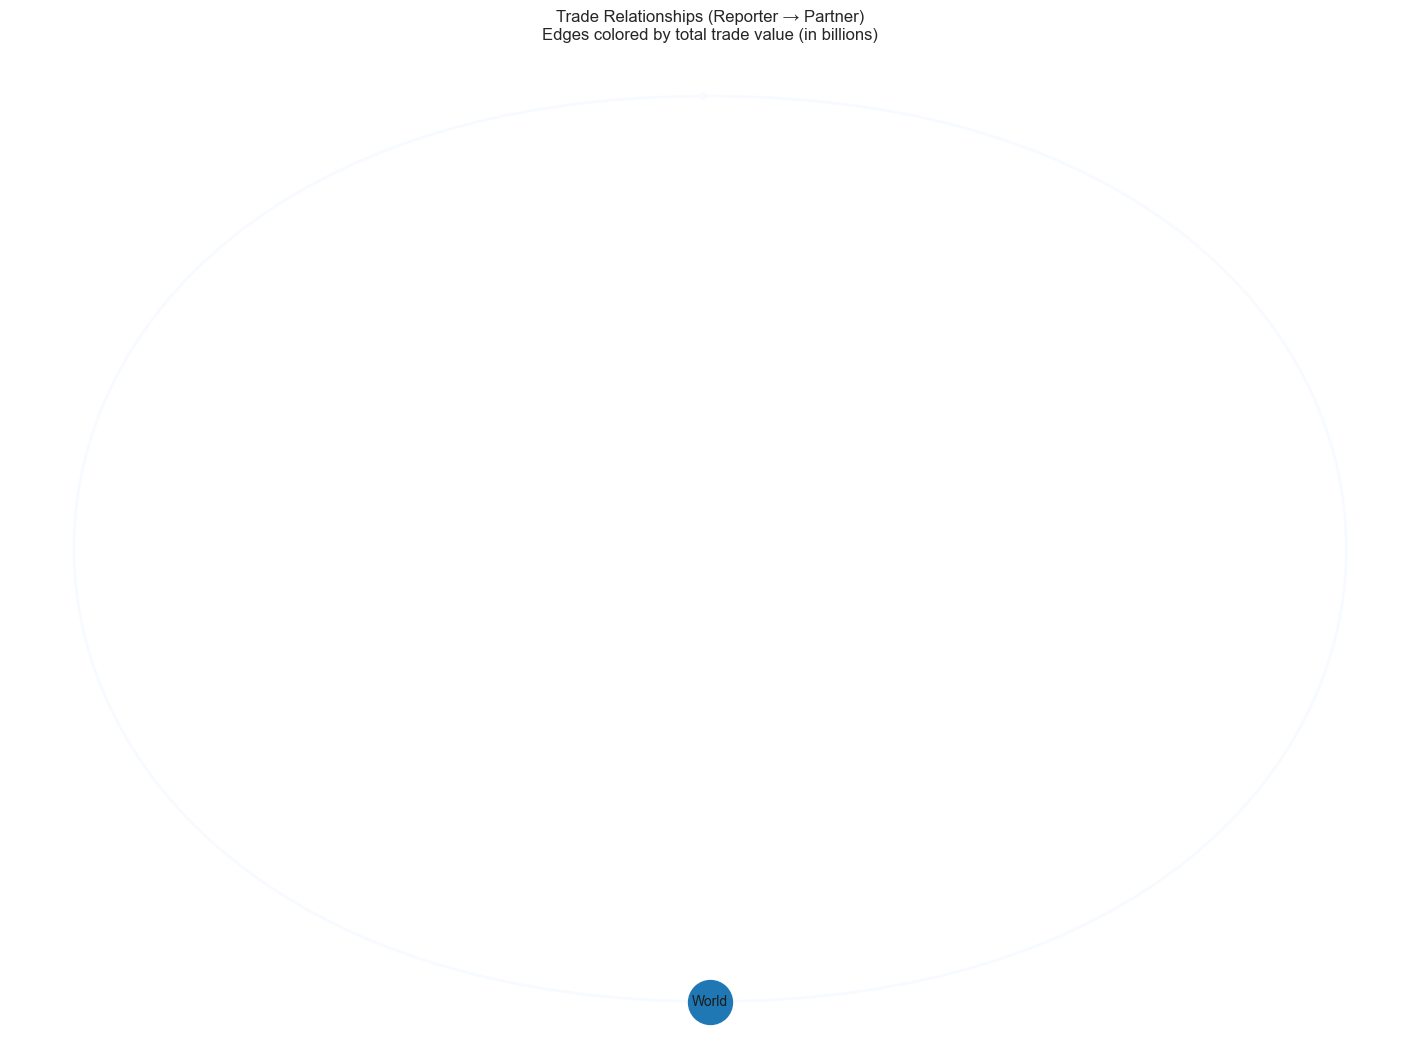

In [52]:
# Ensure Value is numeric
annual_merch_df['Value'] = pd.to_numeric(annual_merch_df['Value'], errors='coerce')

# Group by Reporter and Partner
edges = (
    annual_merch_df
    .groupby(['Reporter', 'Partner'])['Value']
    .sum()
    .reset_index()
)

# Filter for large trade values to reduce clutter (e.g., > 1 billion)
edges = edges[edges['Value'] > 1e9]

# Create graph
G = nx.DiGraph()
for _, row in edges.iterrows():
    G.add_edge(row['Reporter'], row['Partner'], weight=row['Value'])

# Draw graph
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.5)
edges_weights = [G[u][v]['weight'] / 1e9 for u, v in G.edges()]  # scale weights

nx.draw(
    G, pos, with_labels=True, node_size=1000, 
    edge_color=edges_weights, width=2.0,
    edge_cmap=plt.cm.Blues, font_size=10
)

plt.title("Trade Relationships (Reporter → Partner)\nEdges colored by total trade value (in billions)")
plt.show()


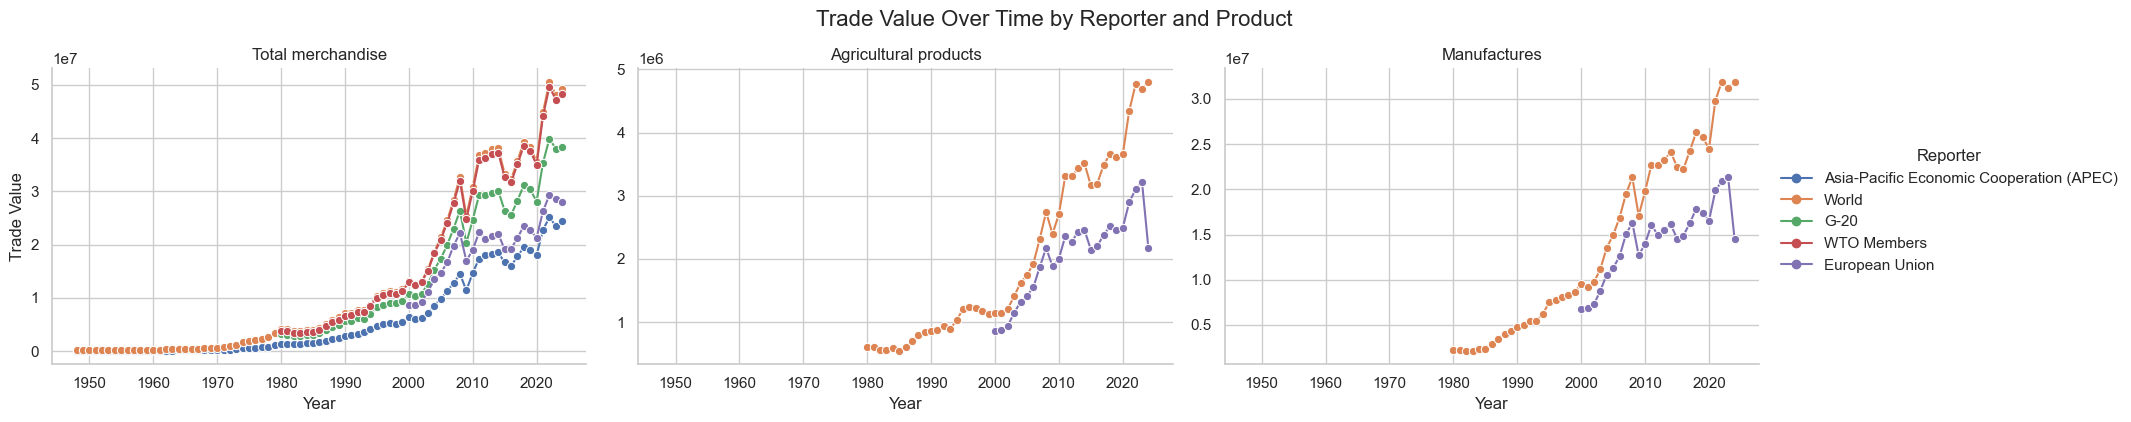

In [53]:
# Ensure Value is numeric
annual_merch_df['Value'] = pd.to_numeric(annual_merch_df['Value'], errors='coerce')

# Optional: filter to key reporters and products to avoid clutter
top_reporters = annual_merch_df.groupby('Reporter')['Value'].sum().nlargest(5).index
top_products = annual_merch_df['Product'].value_counts().nlargest(3).index

filtered_df = annual_merch_df[
    annual_merch_df['Reporter'].isin(top_reporters) &
    annual_merch_df['Product'].isin(top_products)
]

# Group by Year, Reporter, and Product
grouped = (
    filtered_df.groupby(['Year', 'Product', 'Reporter'])['Value']
    .sum()
    .reset_index()
)

# Plot using seaborn
sns.set(style = "whitegrid")
g = sns.relplot(
    data = grouped,
    x = 'Year', y='Value',
    kind = 'line',
    hue = 'Reporter',
    col = 'Product',
    facet_kws = {'sharey': False, 'sharex': True},
    height = 4, aspect = 1.5,
    marker = "o"
)

g.set_titles(col_template = "{col_name}")
g.set_axis_labels("Year", "Trade Value")
g.fig.suptitle("Trade Value Over Time by Reporter and Product", fontsize = 16, y = 1.05)
plt.show()


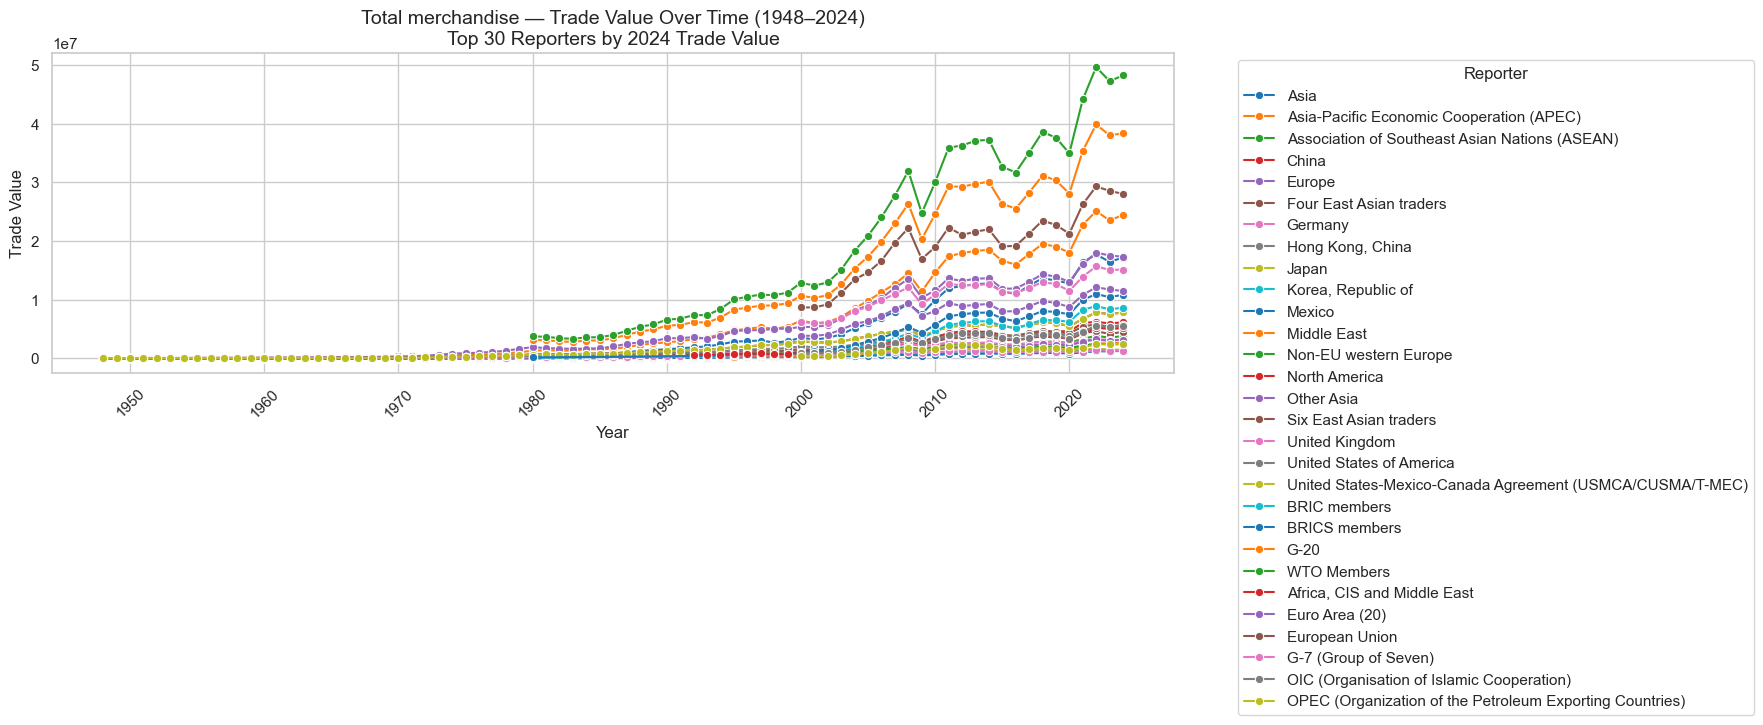

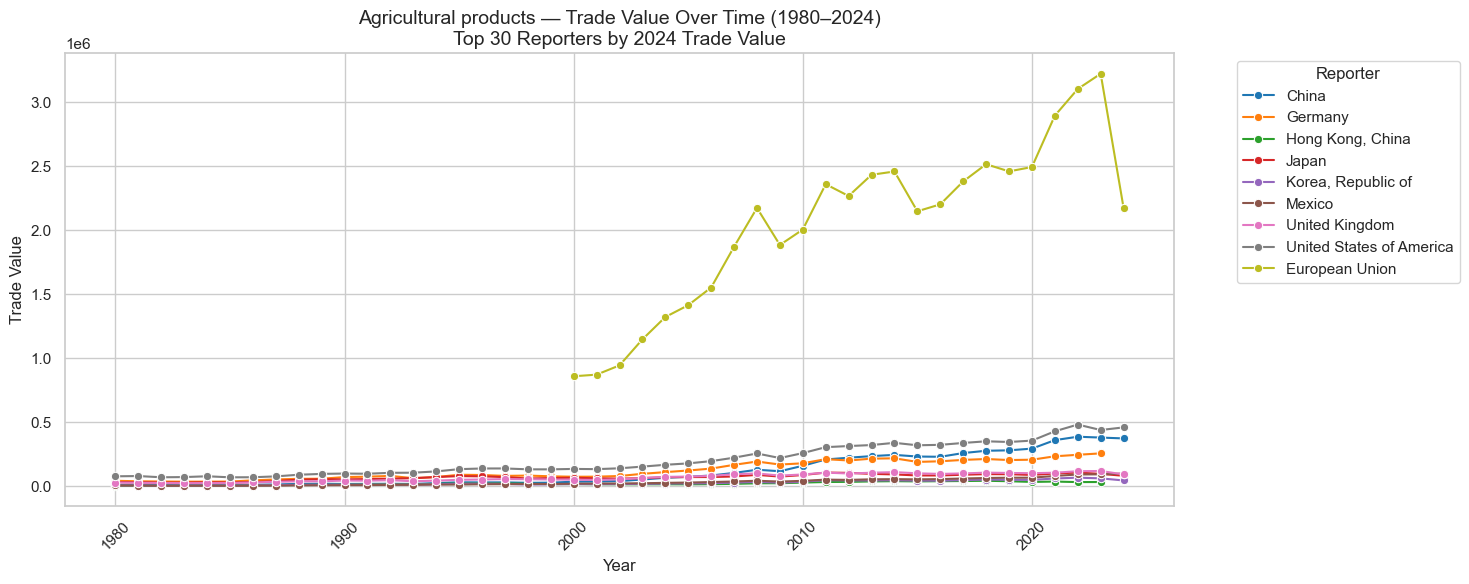

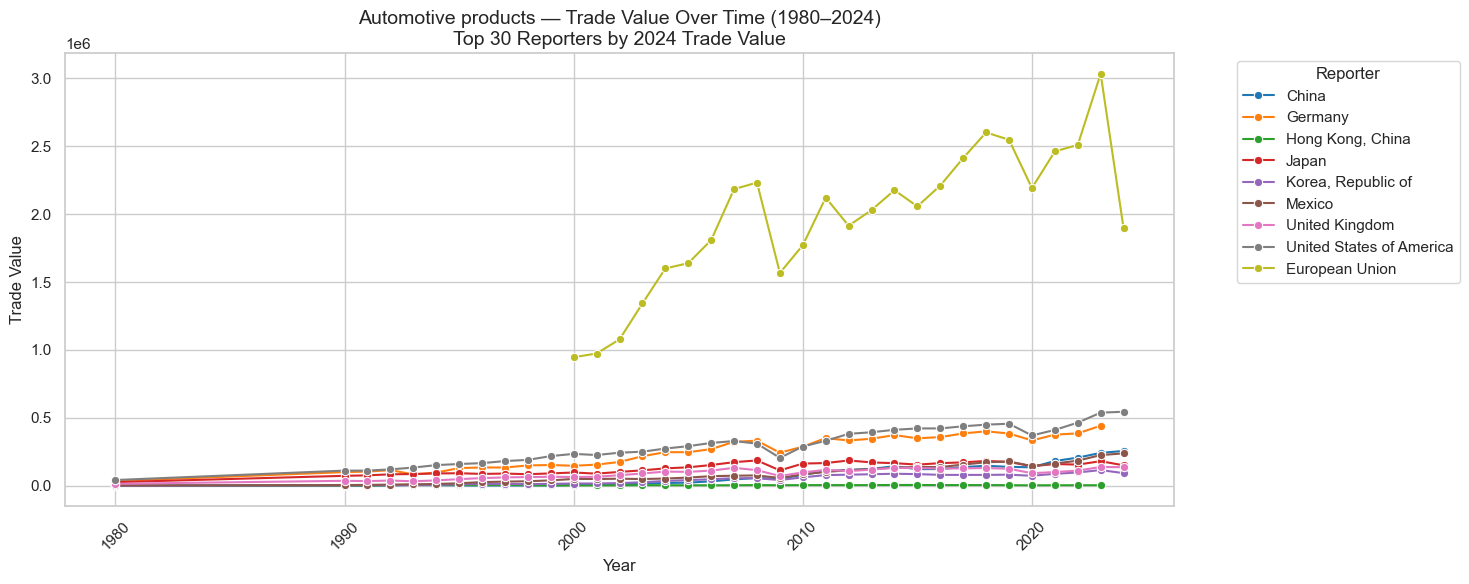

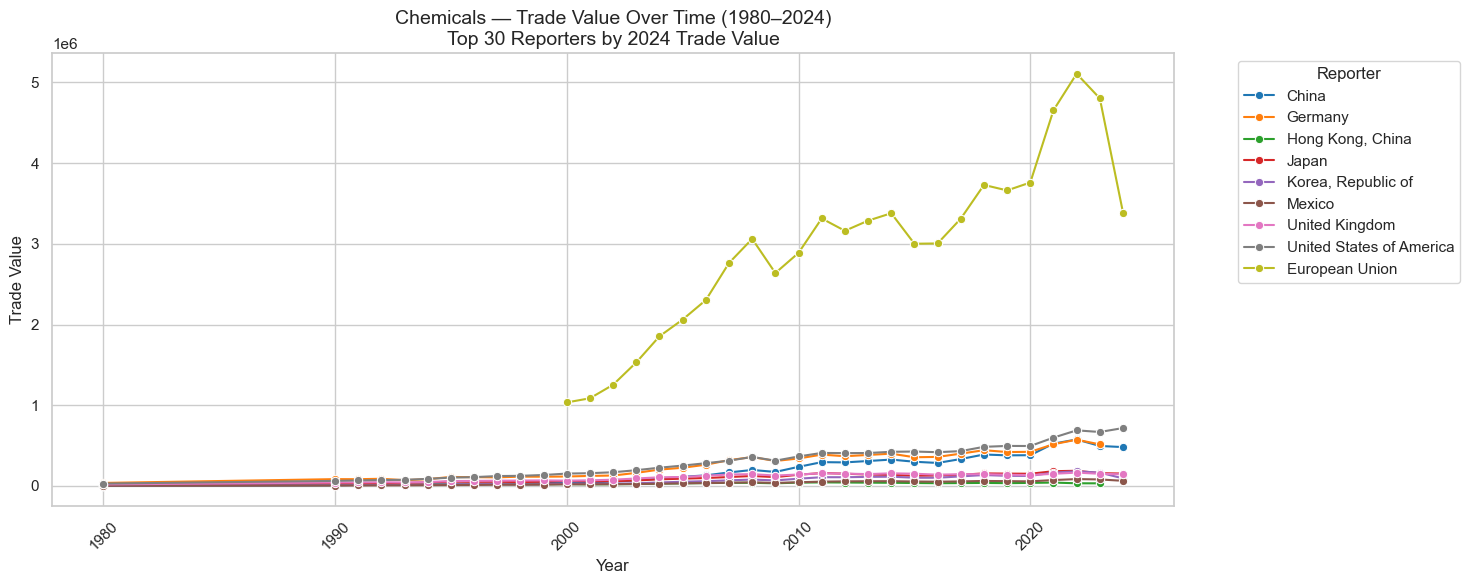

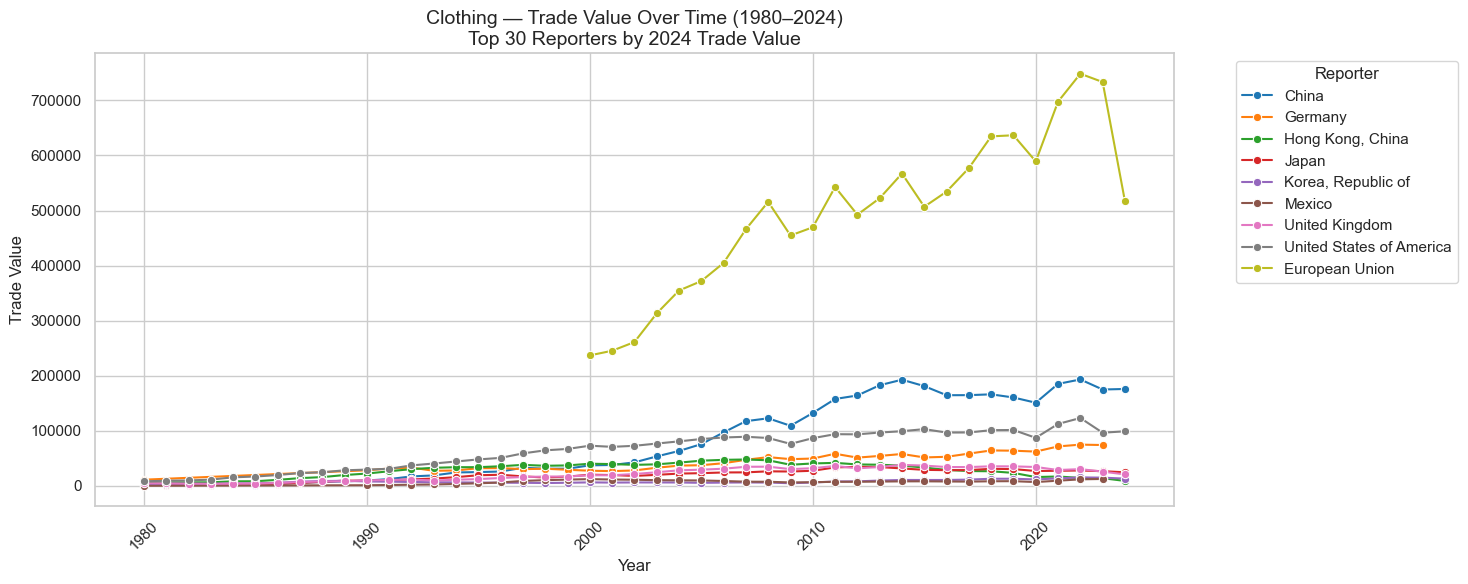

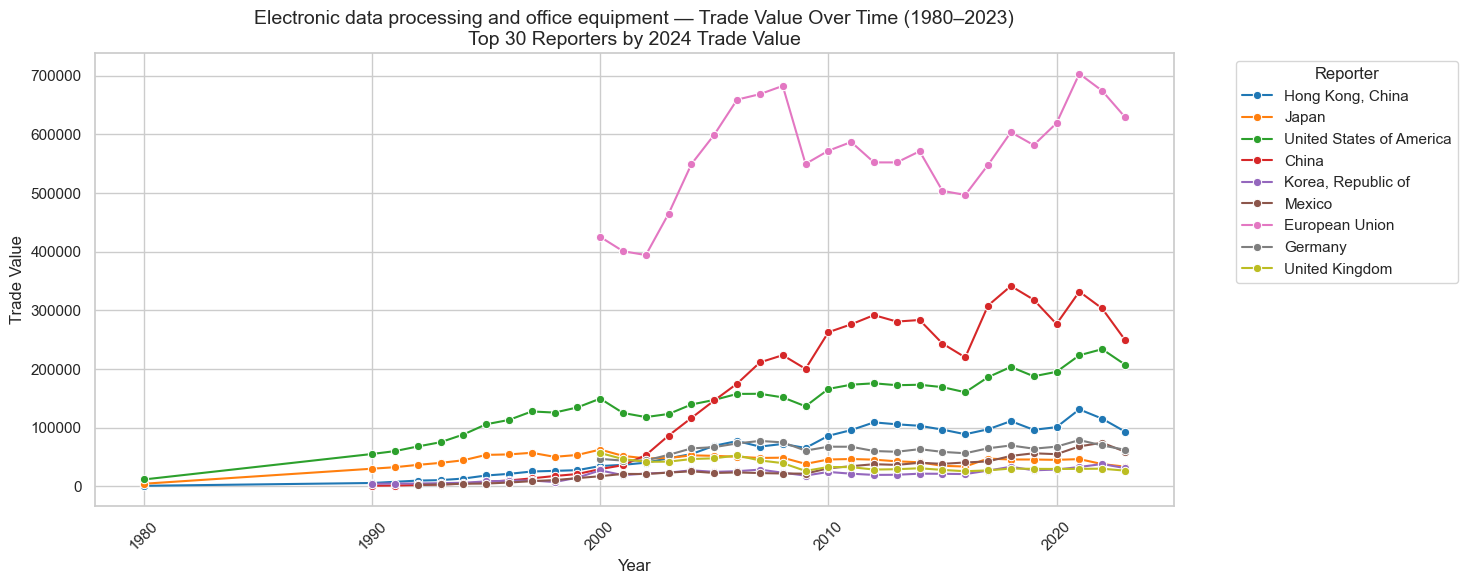

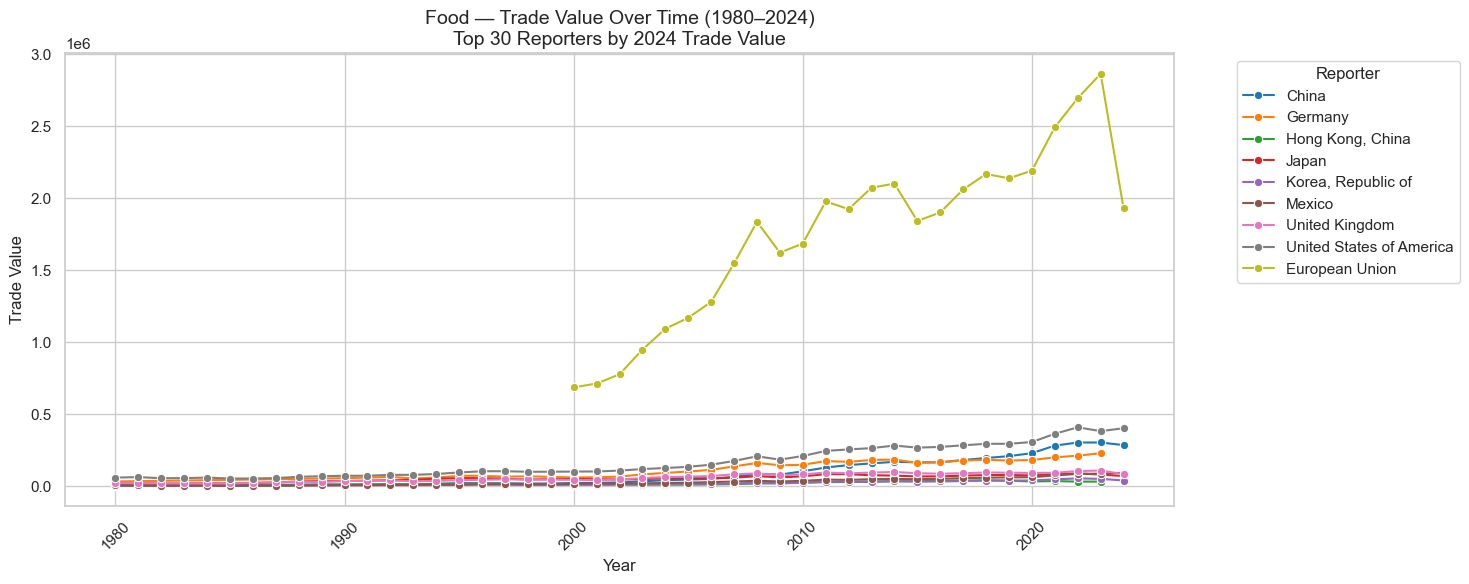

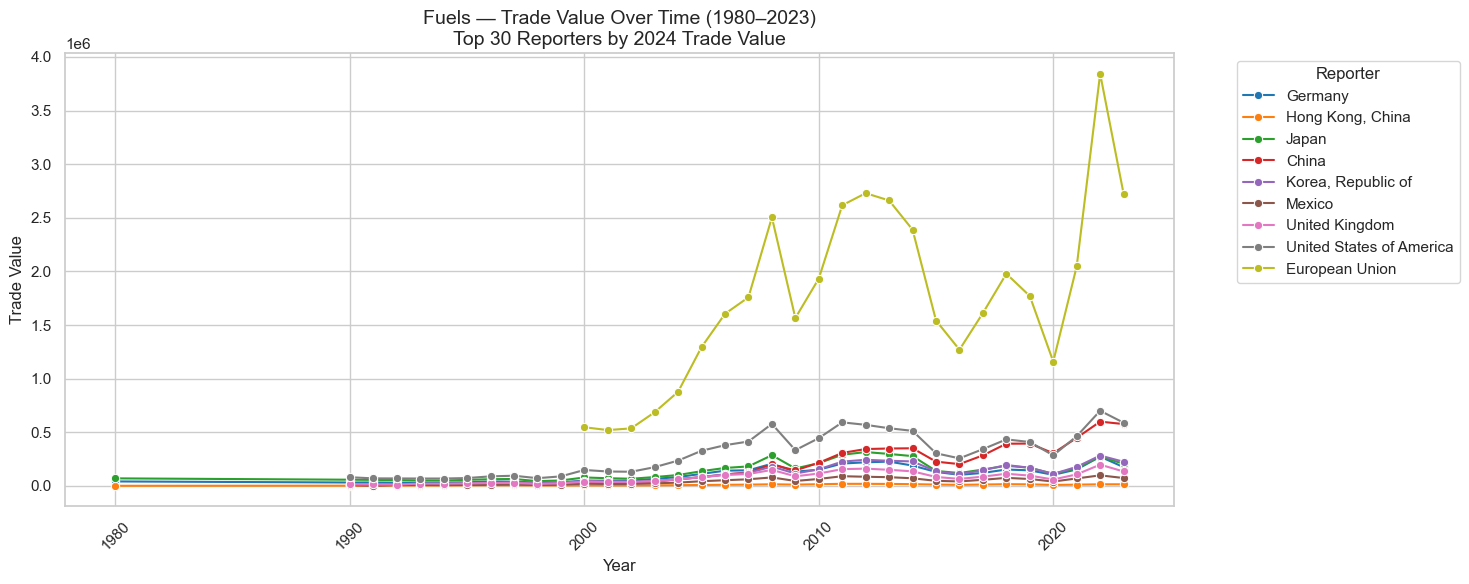

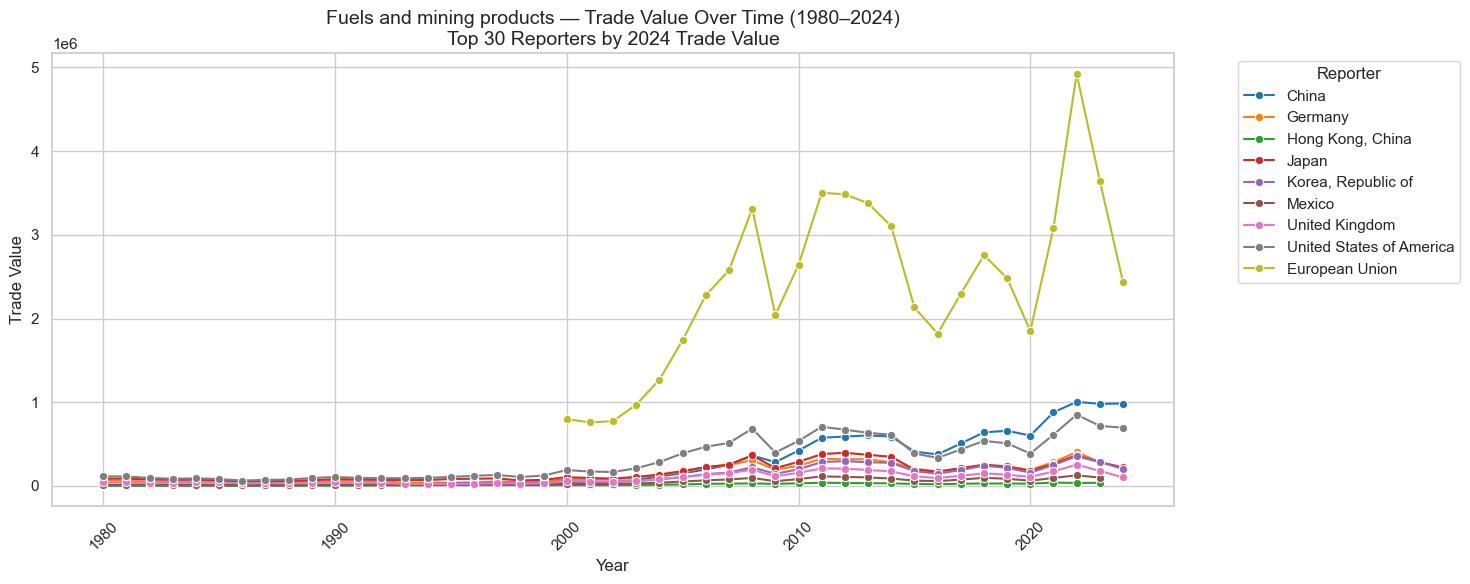

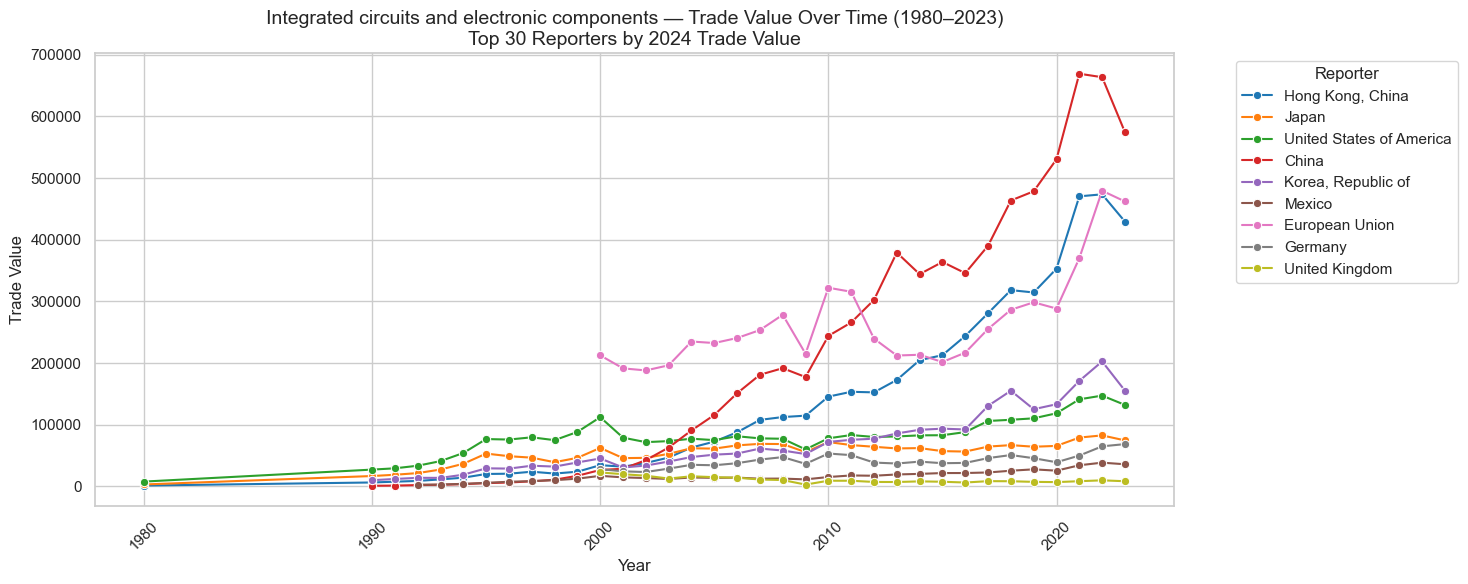

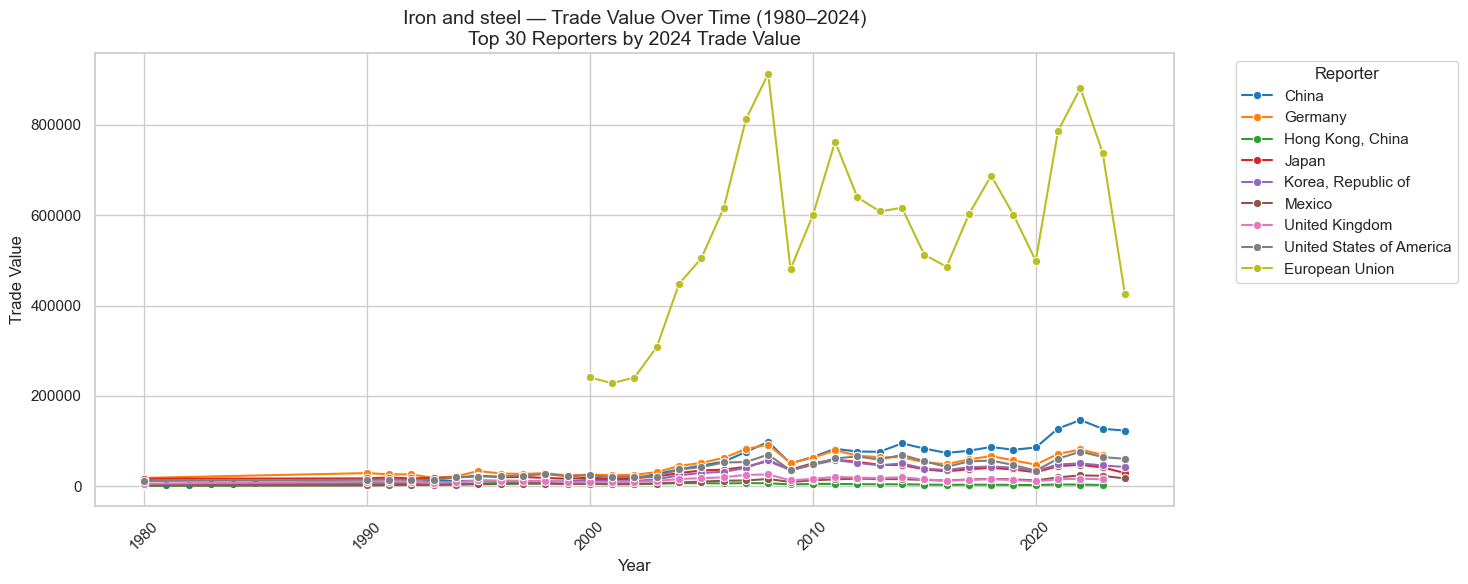

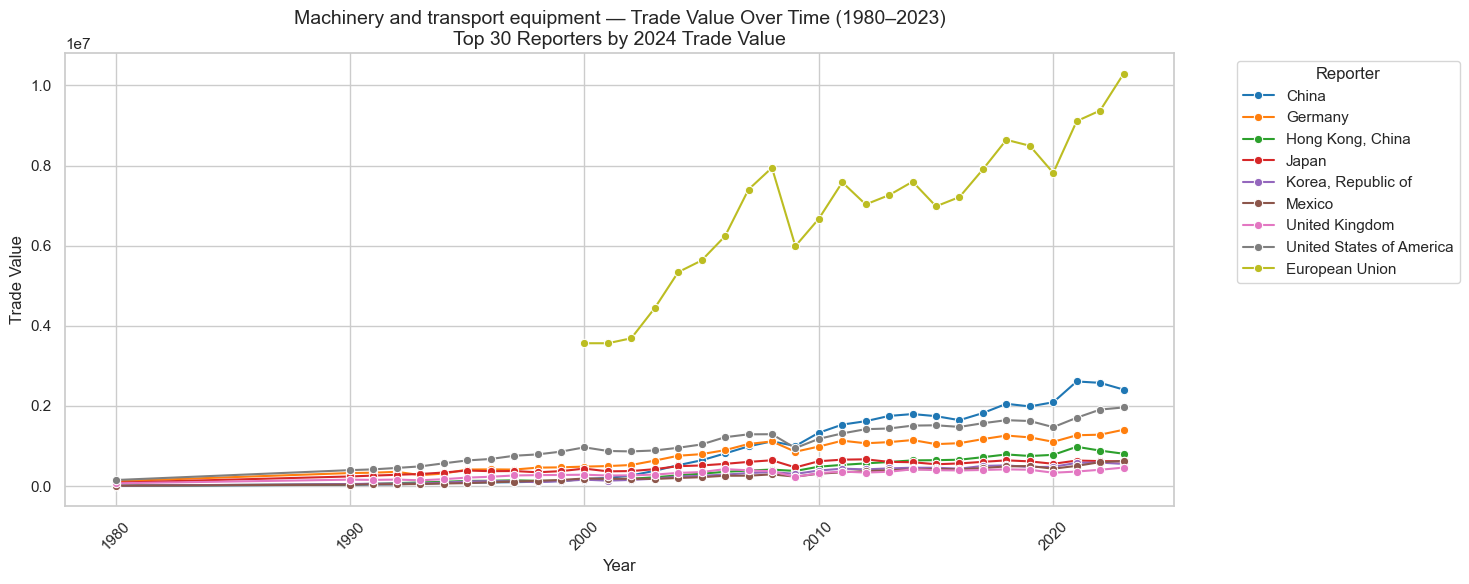

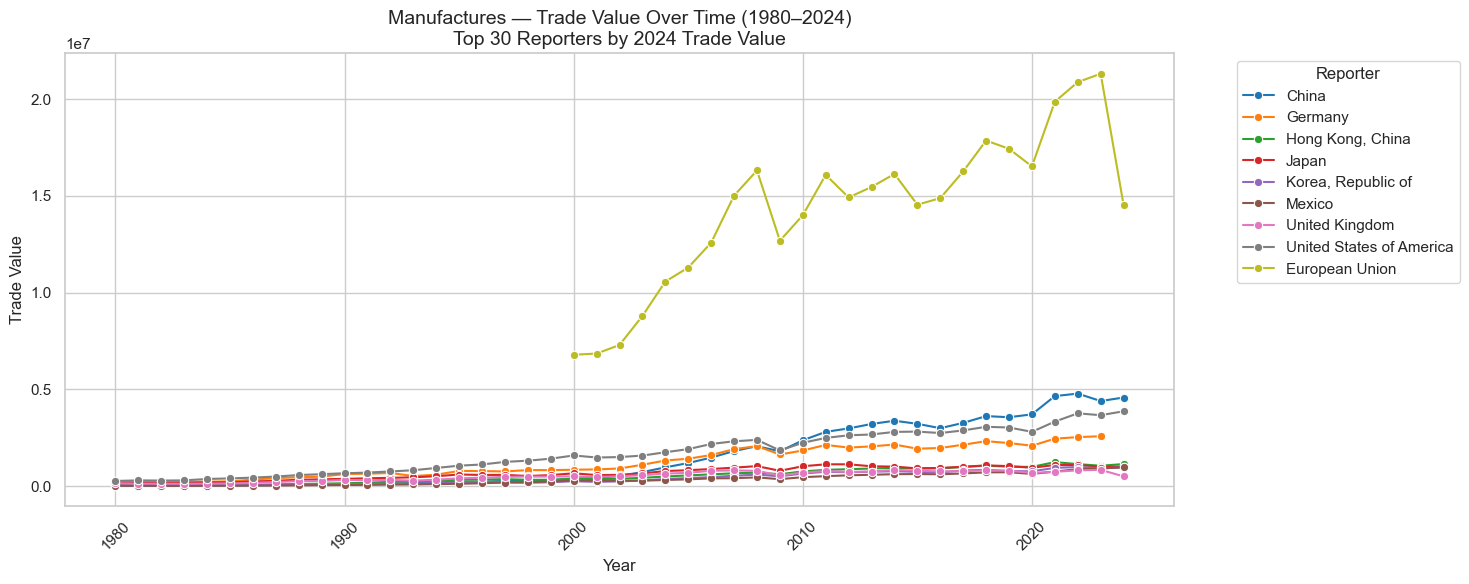

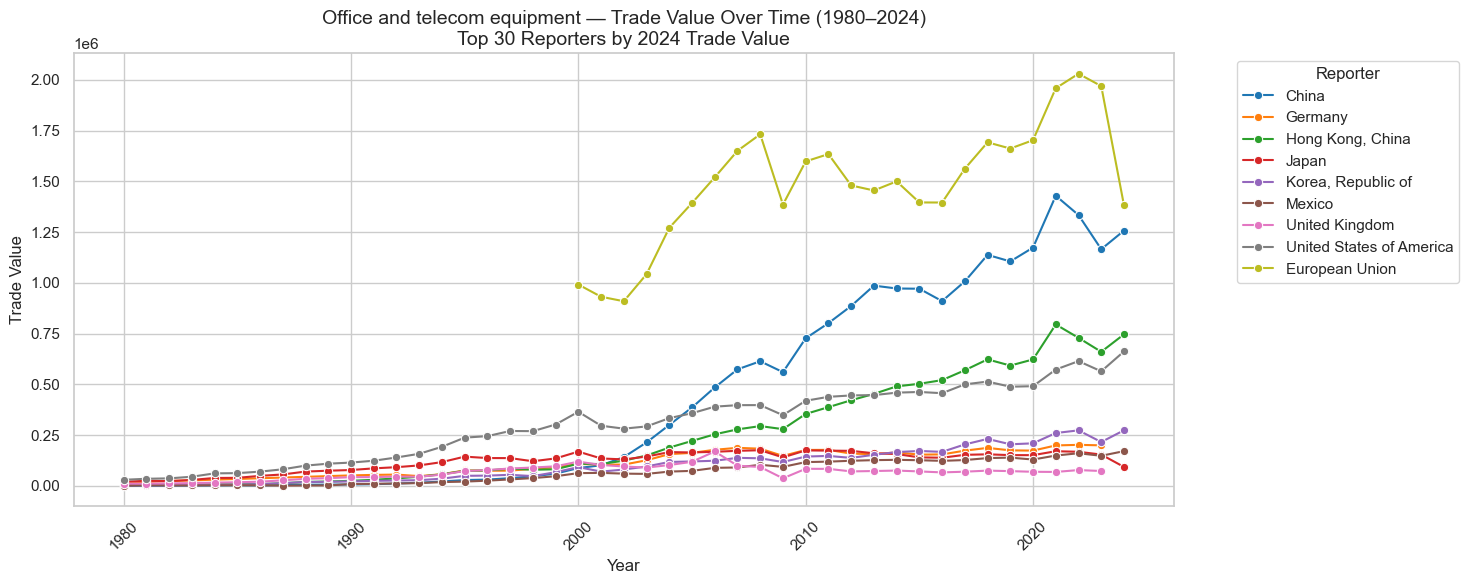

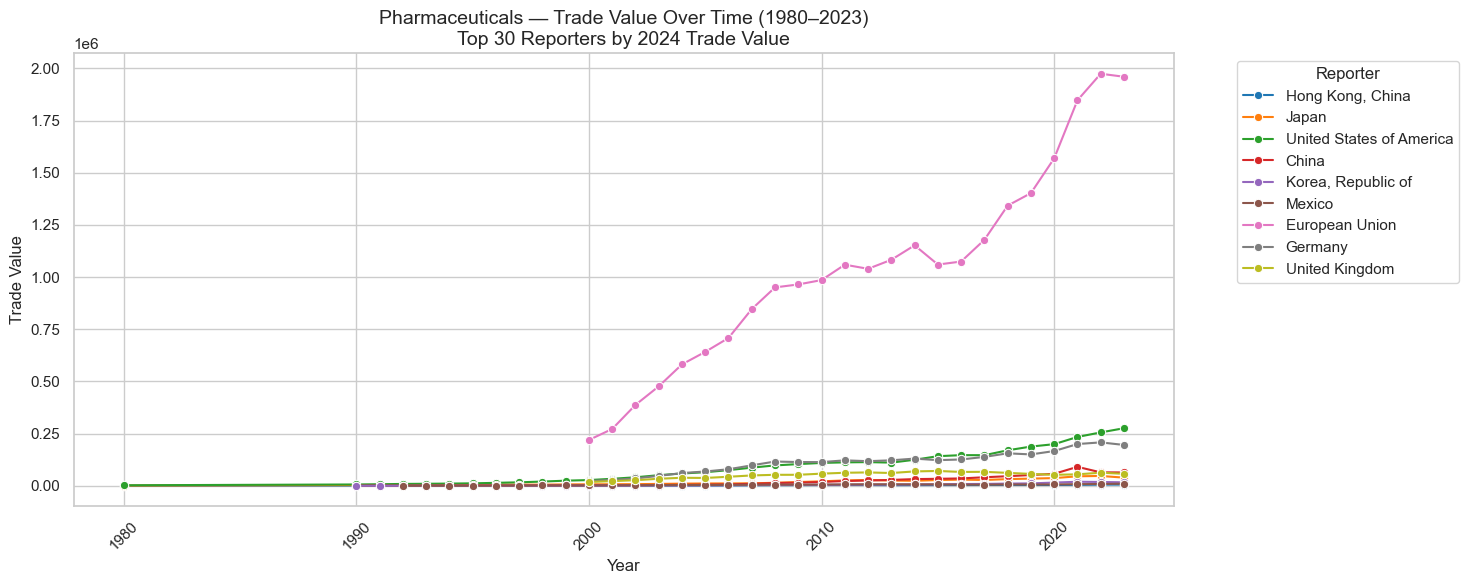

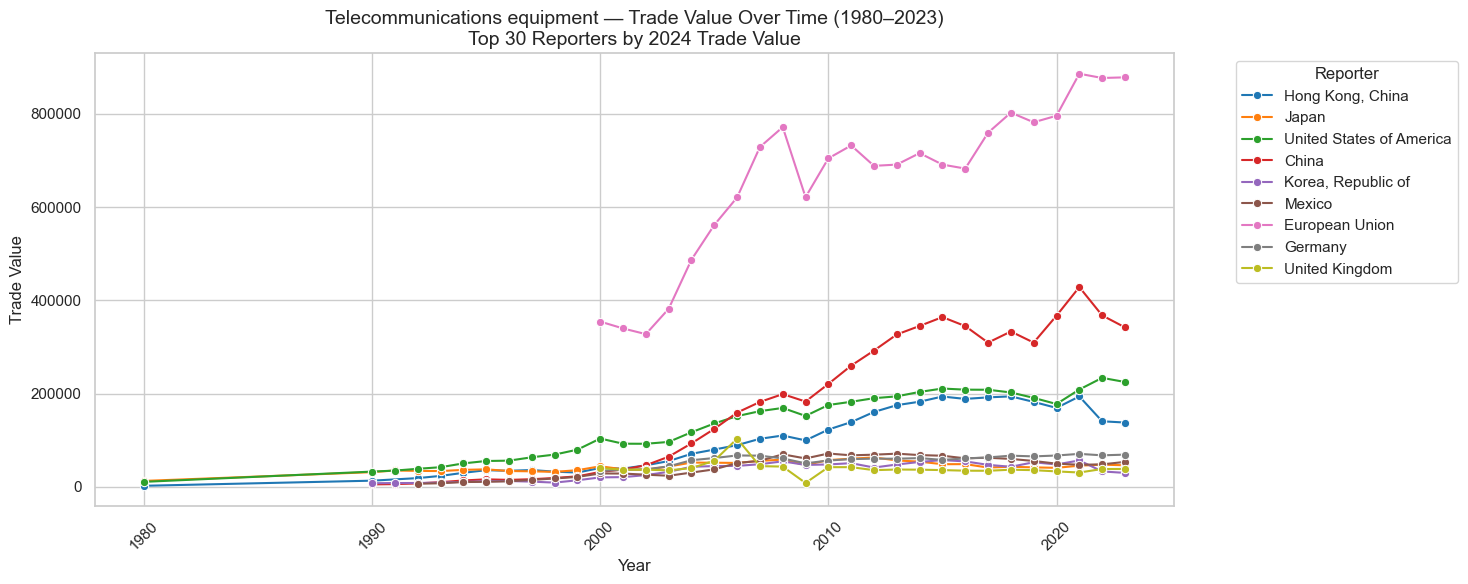

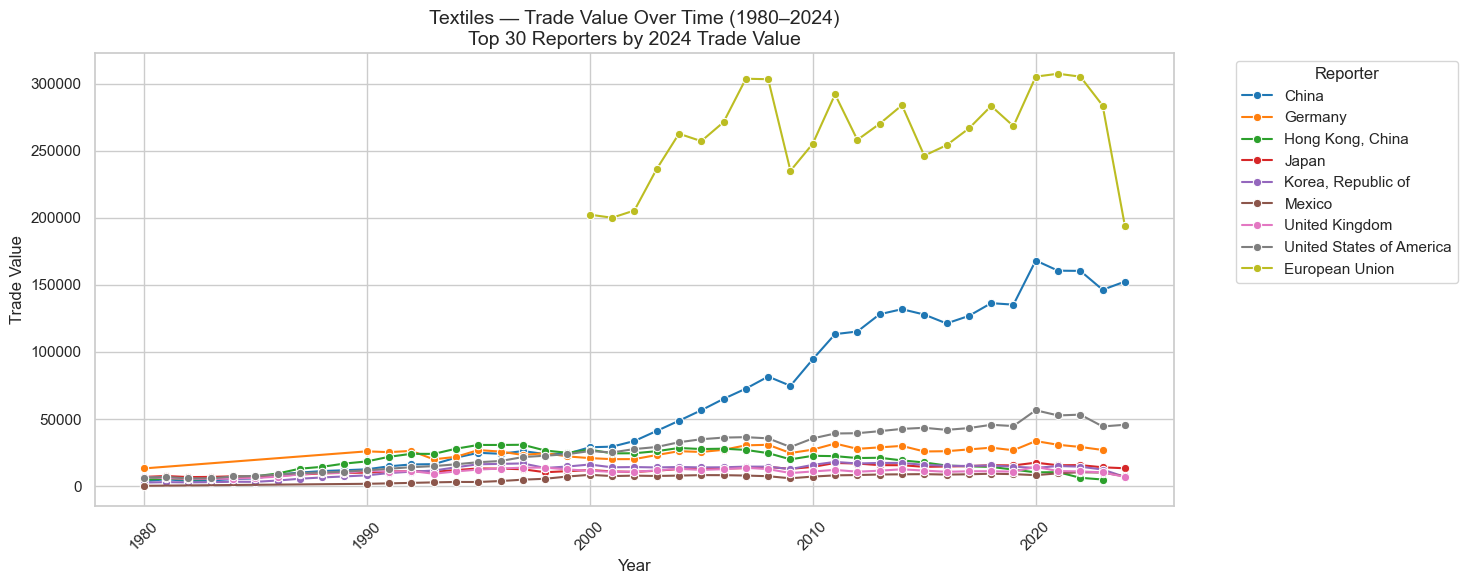

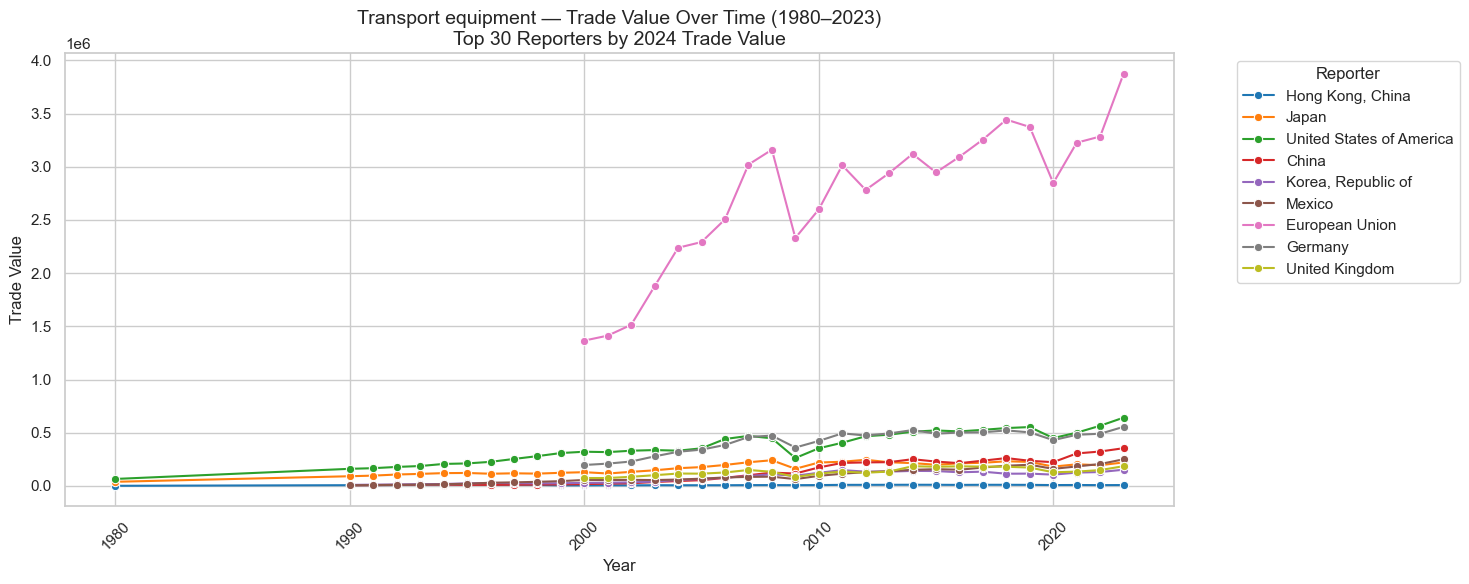

In [60]:
# Ensure 'Value' is numeric
annual_merch_df['Value'] = pd.to_numeric(annual_merch_df['Value'], errors='coerce')

# Dynamic Changes
year = 2024
top = 30

# Identify top x year Reporters by 2024 total trade value
top_reporters = (
    annual_merch_df[annual_merch_df['Year'] == year]
    .groupby('Reporter')['Value']
    .sum()
    .nlargest(top)
    .index
)

# Filter to those reporters only
excluded_reporters = ['World', 'Reporter2', 'Reporter3']
df_filtered = annual_merch_df[
    (annual_merch_df['Reporter'].isin(top_reporters)) & 
    (~annual_merch_df['Reporter'].isin(excluded_reporters))
]


# Group data by Year, Product, and Reporter
grouped = (
    df_filtered.groupby(['Year', 'Product', 'Reporter'])['Value']
    .sum()
    .reset_index()
)

# Get unique products
products = grouped['Product'].dropna().unique()

# Set seaborn style
sns.set(style="whitegrid")

# Save path for graphs
vis_path = 'visualisations/merch_products/'

# Loop through each product to plot separately
for product in products:
    product_df = grouped[grouped['Product'] == product]

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=product_df,
        x='Year', y='Value',
        hue='Reporter', marker='o', palette='tab10'
    )

    min_year = int(product_df['Year'].min())
    max_year = int(product_df['Year'].max())

    plt.title(f"{product} — Trade Value Over Time ({min_year}–{max_year})\nTop {top} Reporters by {year} Trade Value", fontsize=14)
    plt.xlabel("Year")
    plt.ylabel("Trade Value")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend(title='Reporter', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.savefig(f"{vis_path}{product}_top_{top}_trade_over_time.png", bbox_inches='tight')
    plt.show()


C:\Users\lachl\AppData\Local\Temp\ipykernel_12464\3072087410.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['Value'] /= 1_000_000
C:\Users\lachl\AppData\Local\Temp\ipykernel_12464\3072087410.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_excluded['Value'] /= 1_000_000


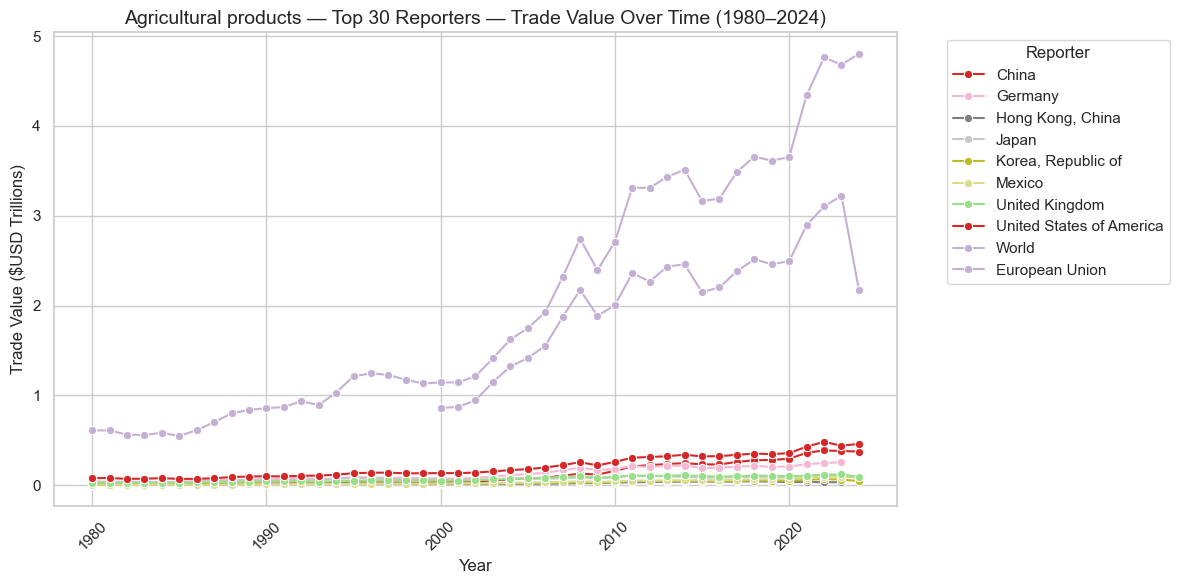

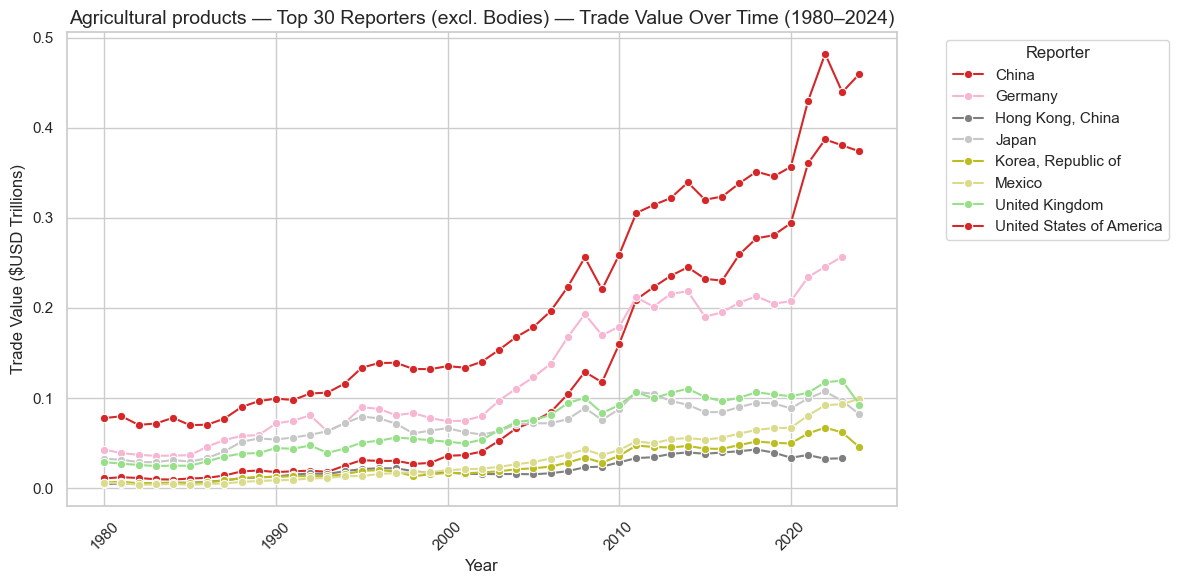

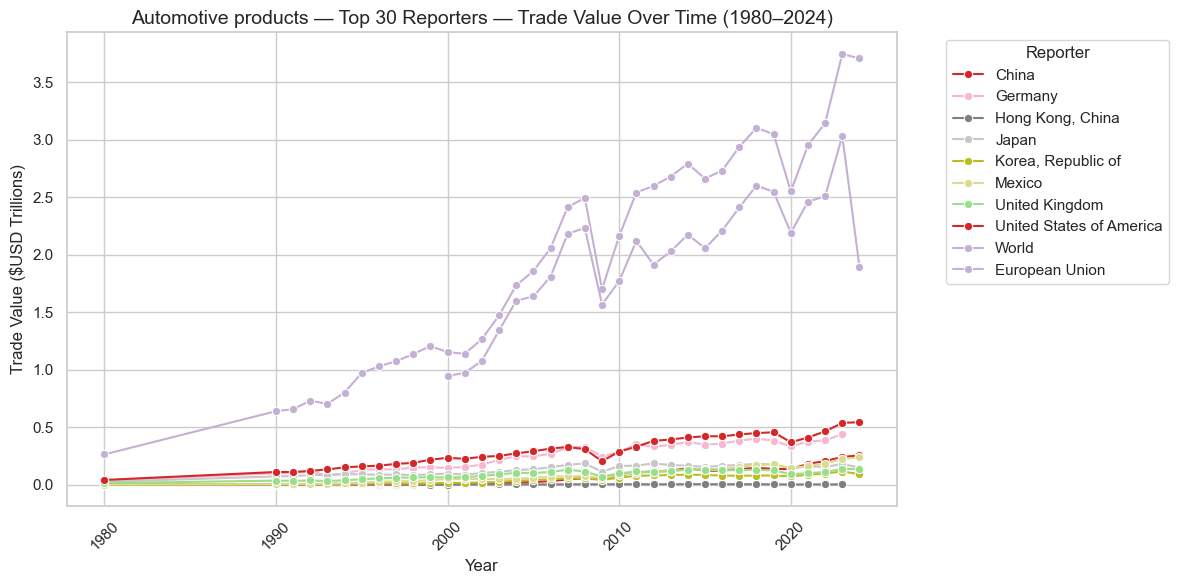

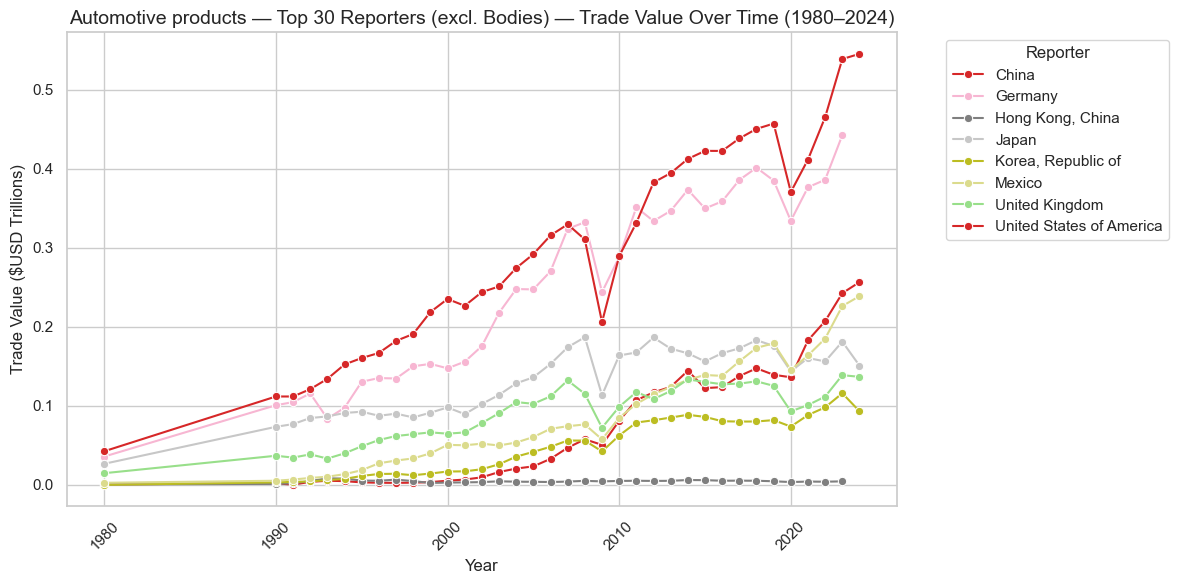

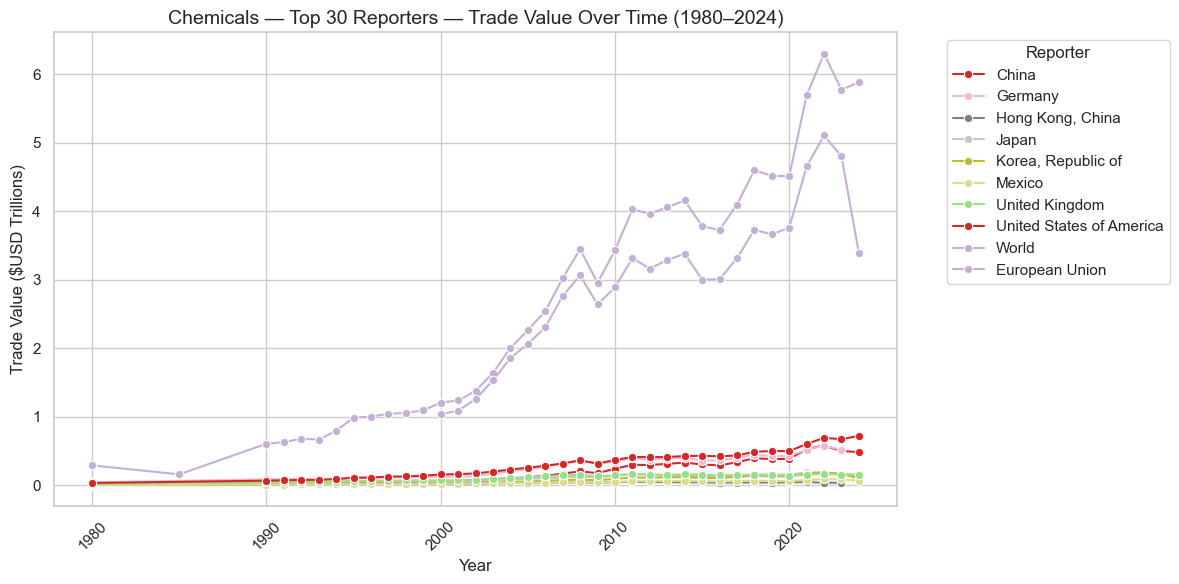

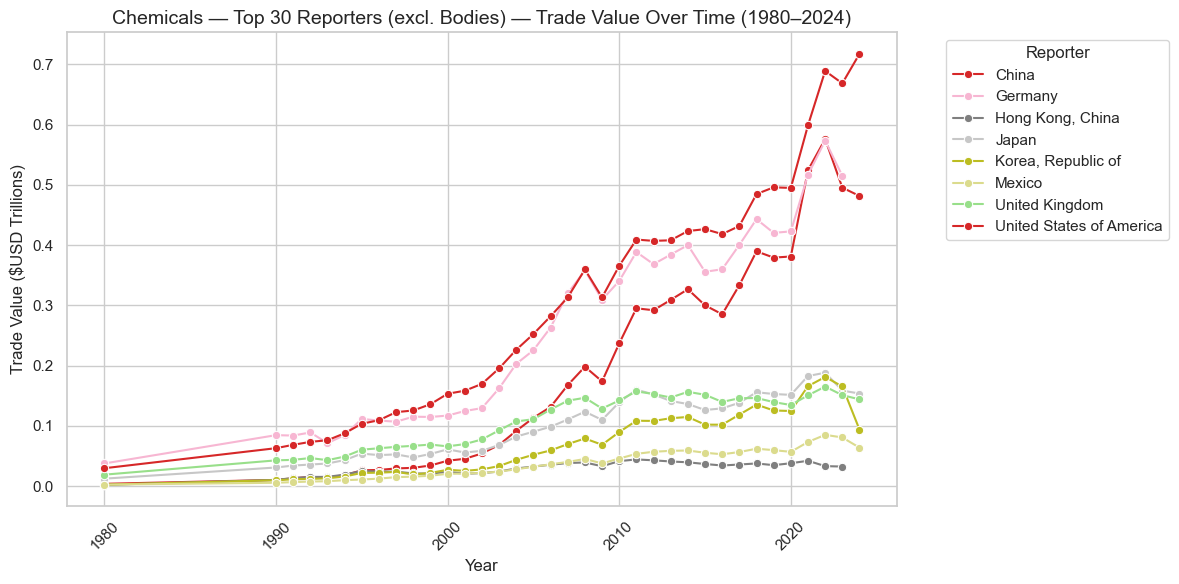

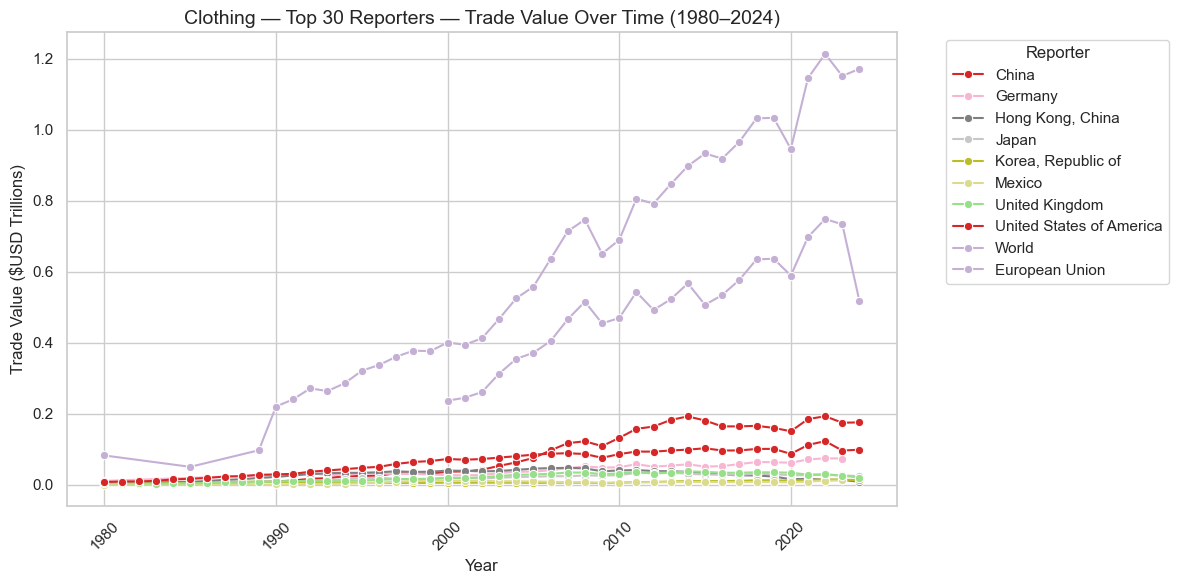

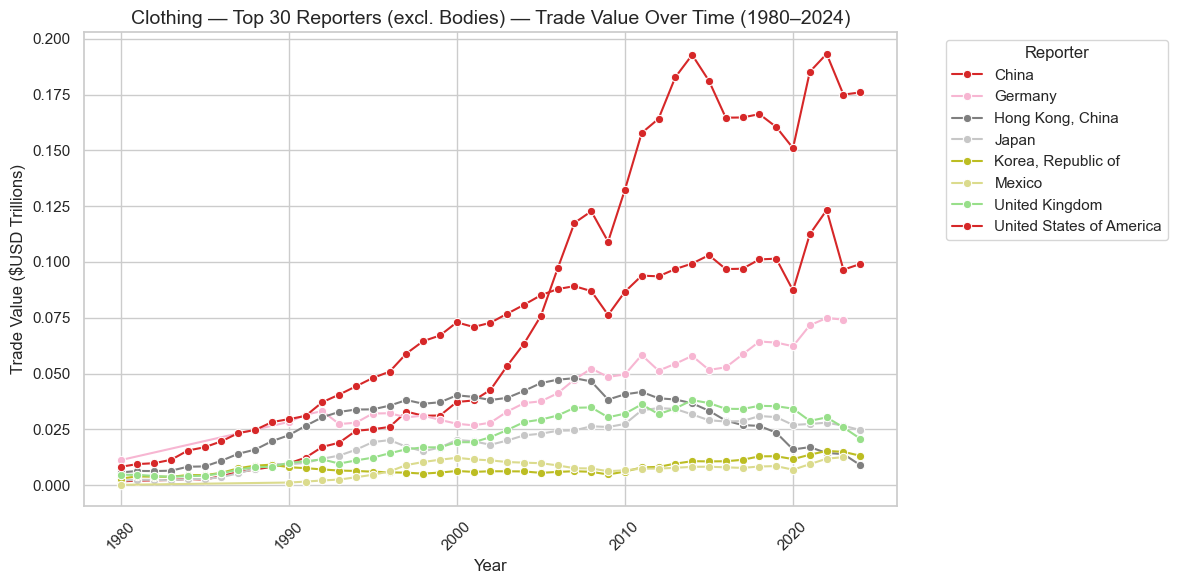

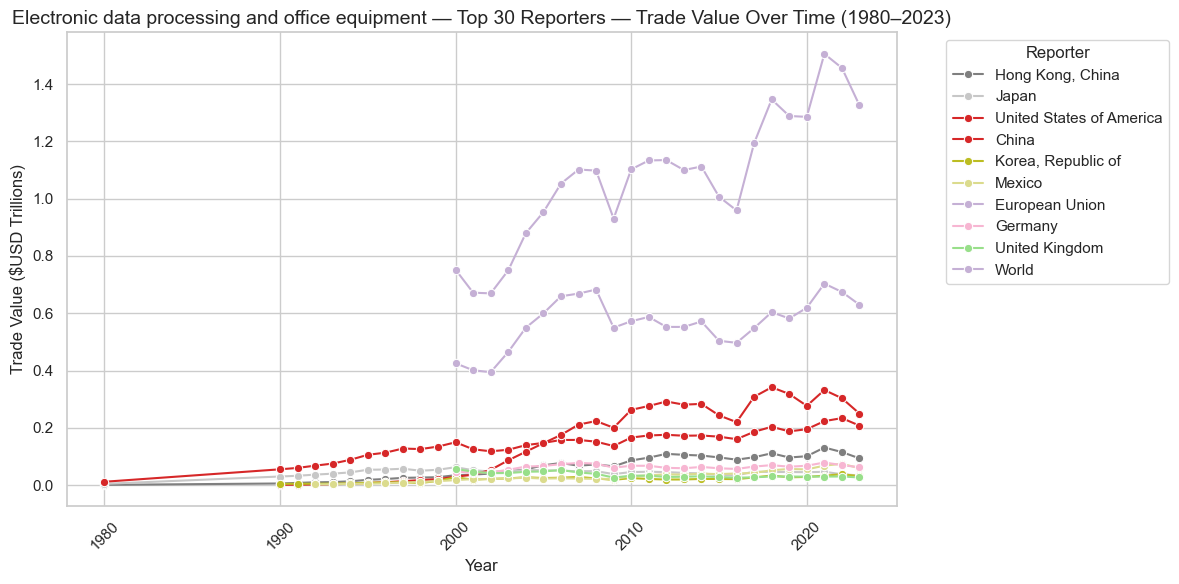

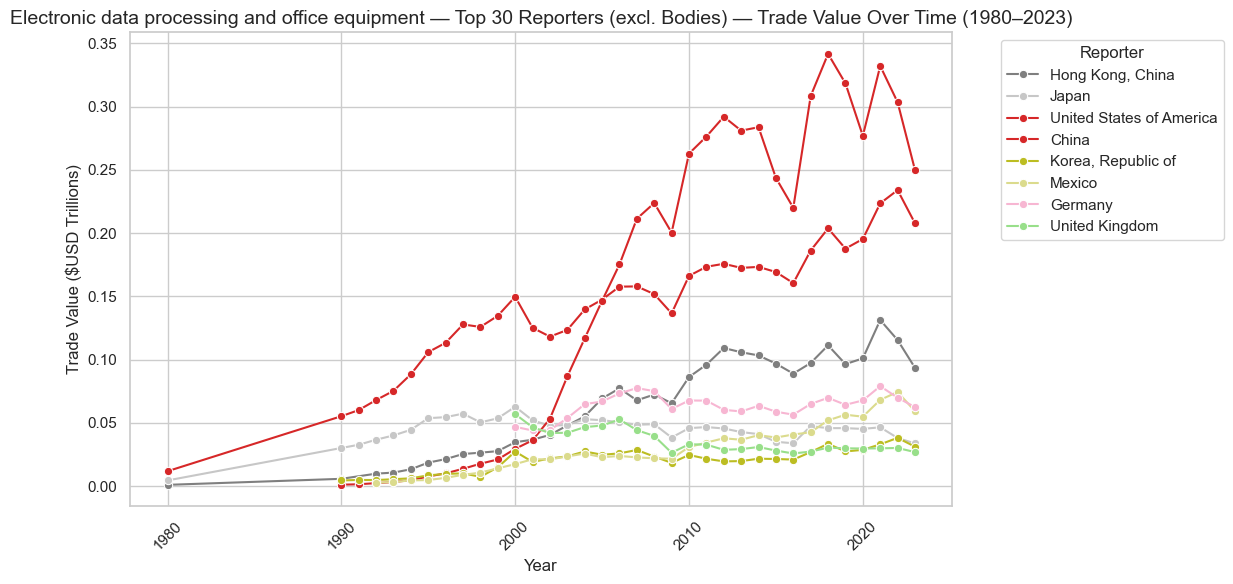

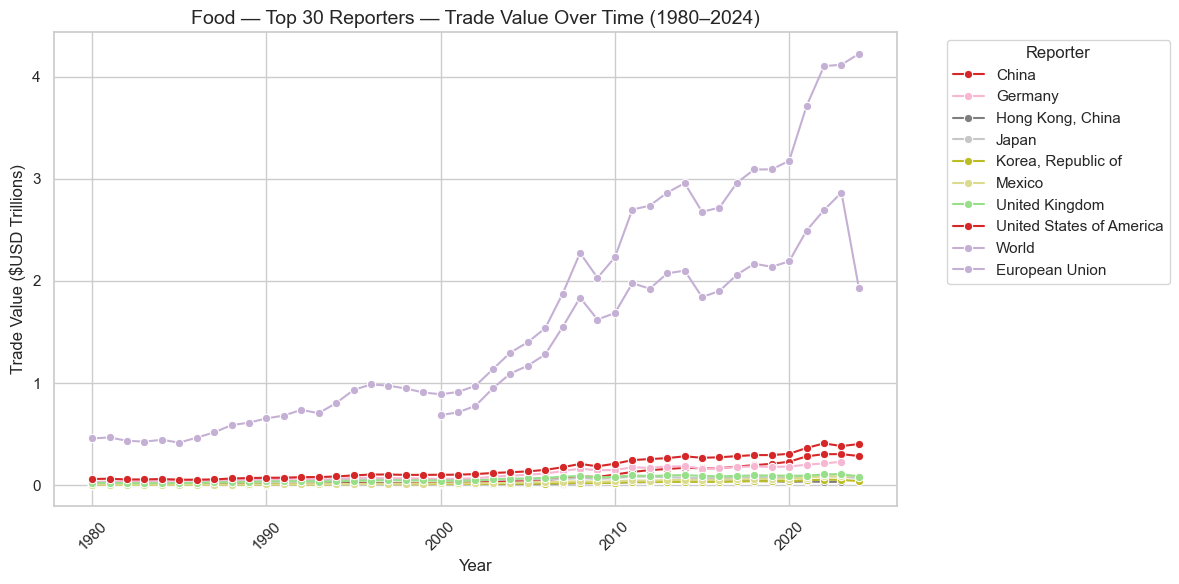

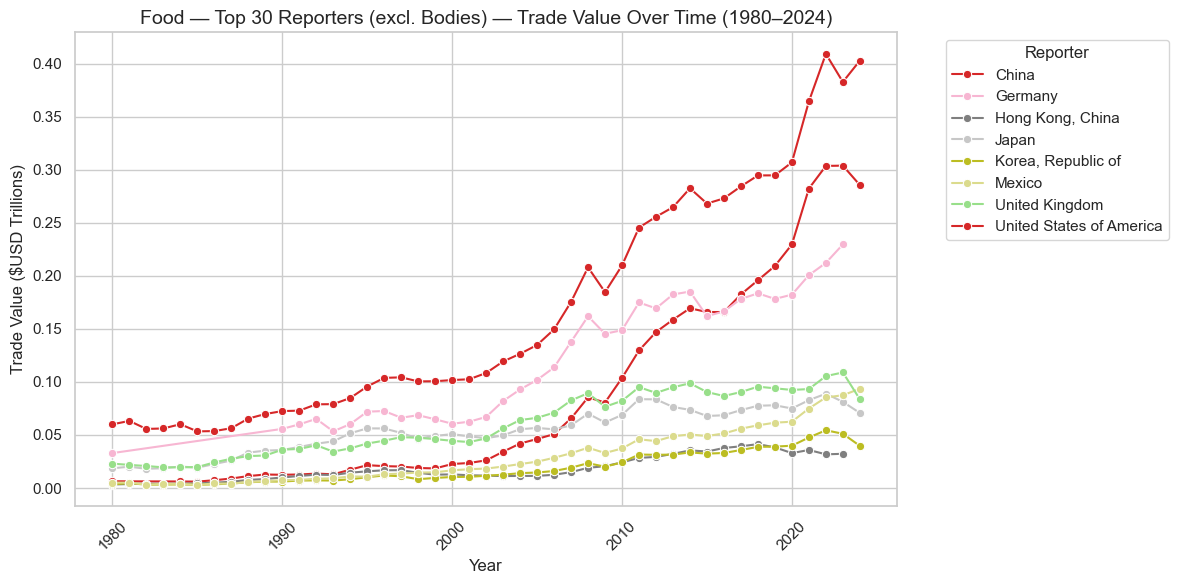

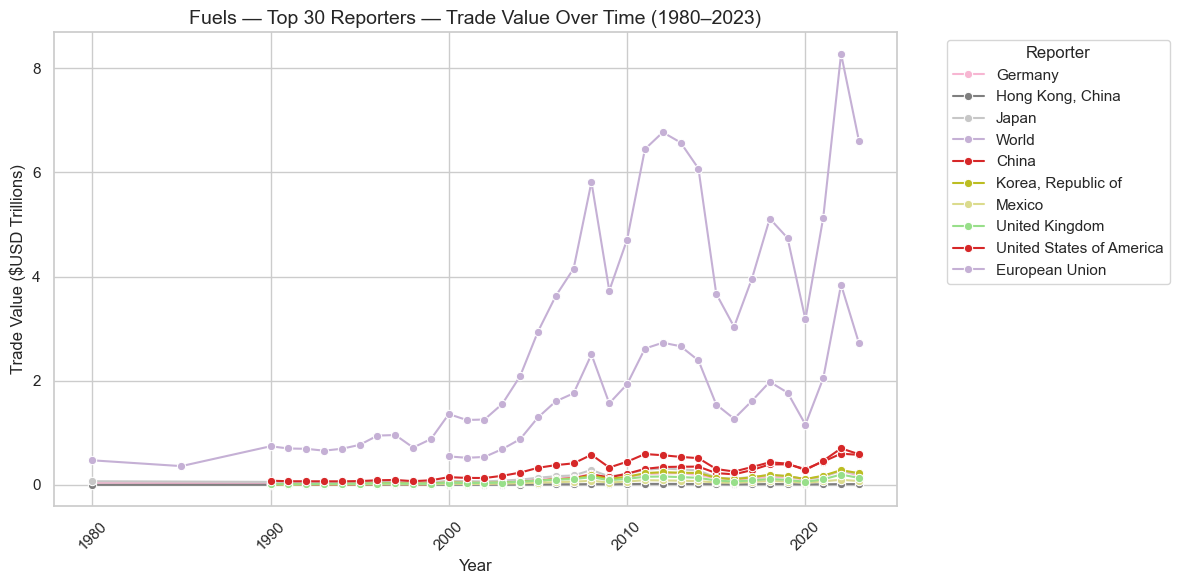

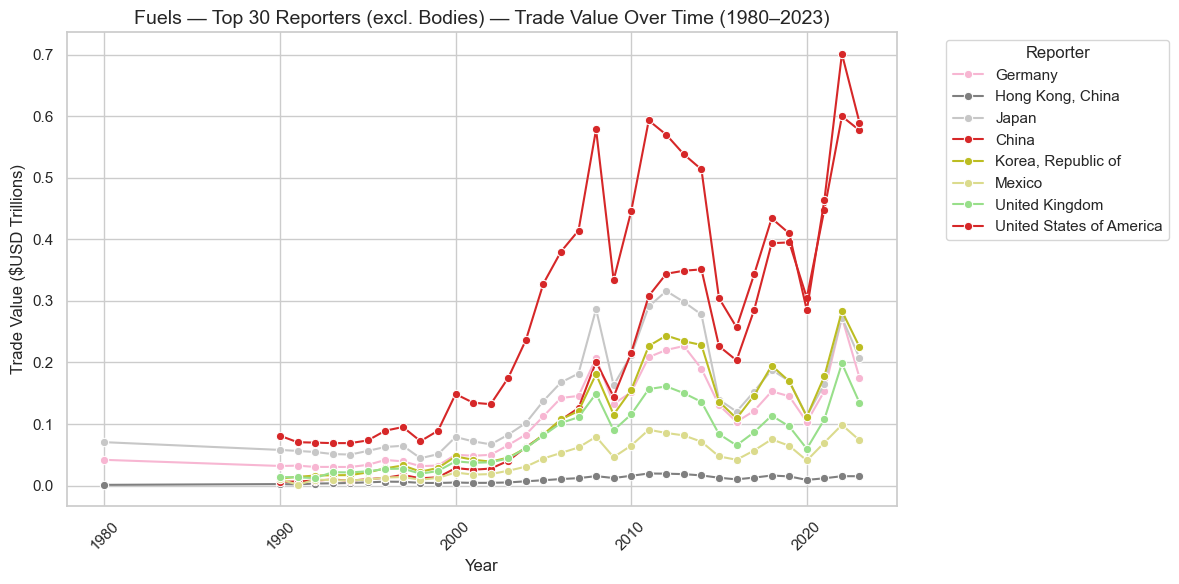

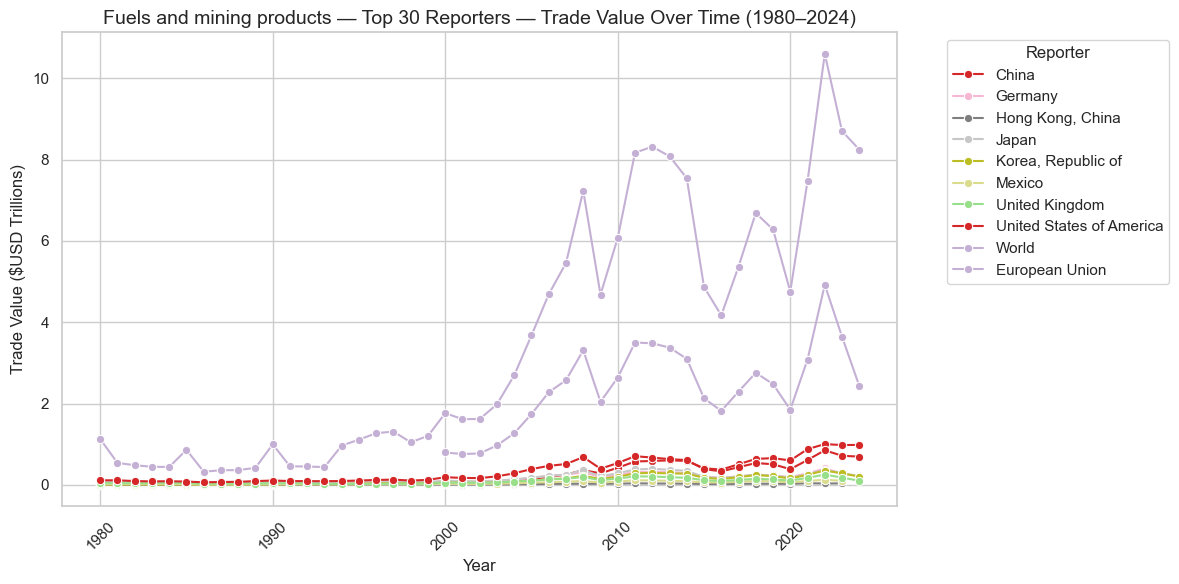

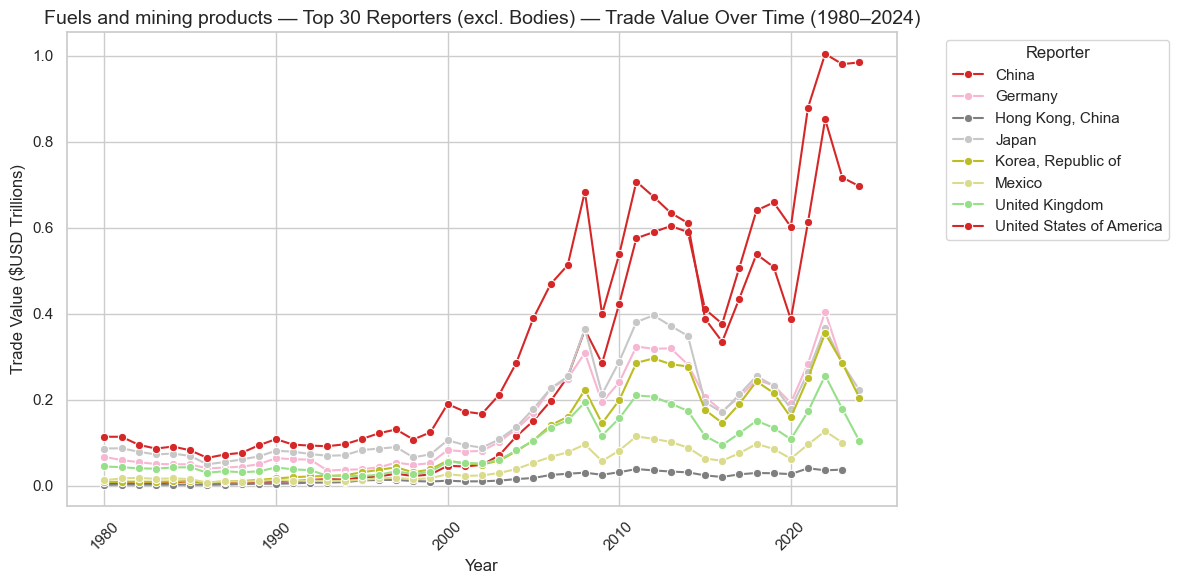

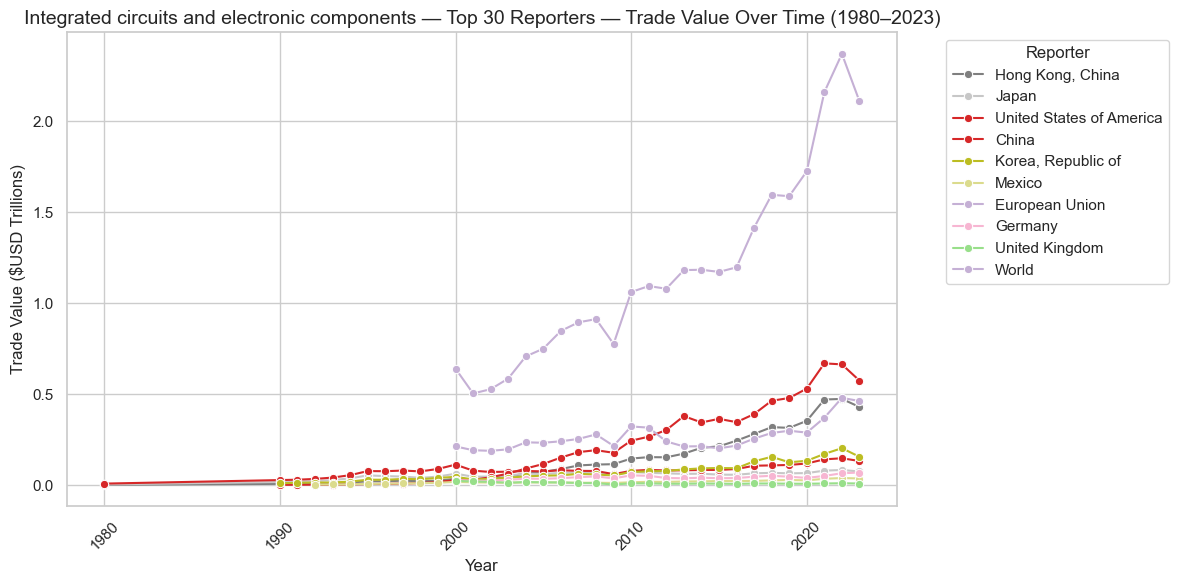

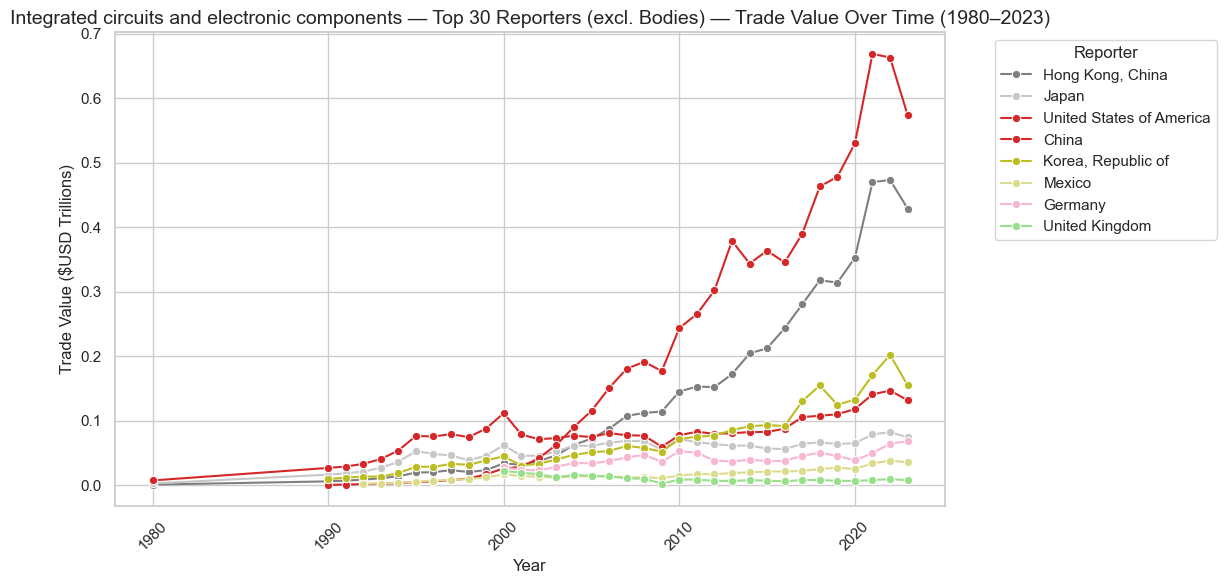

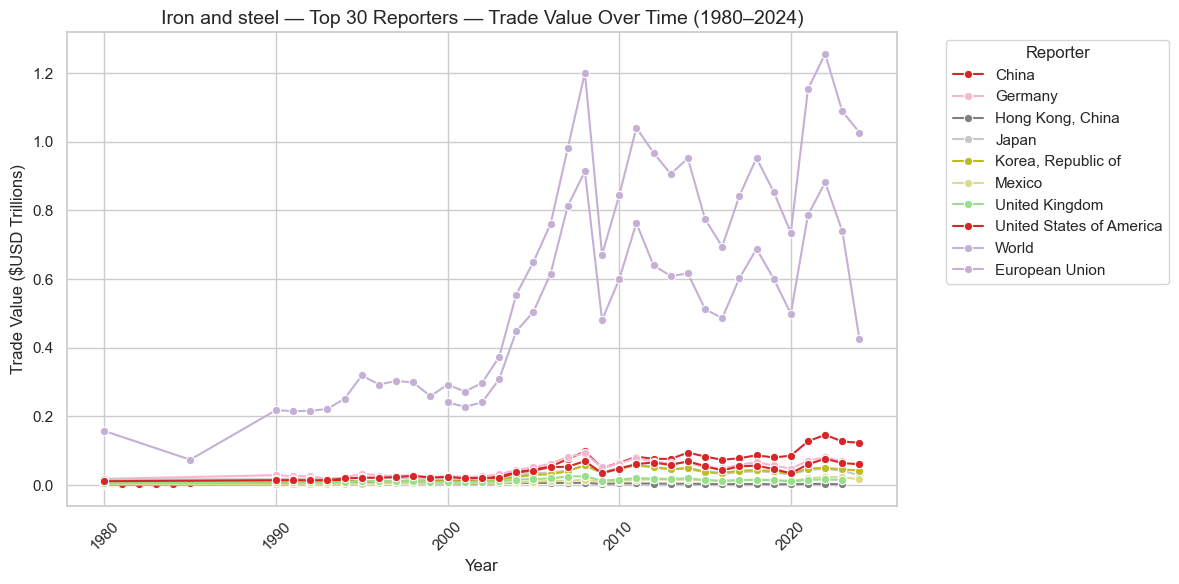

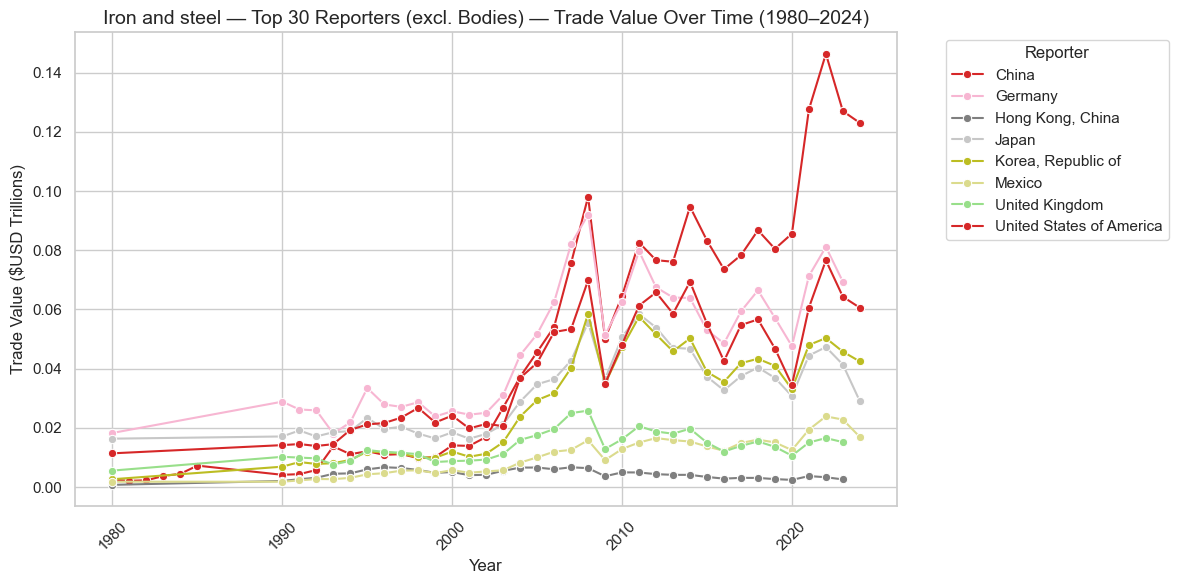

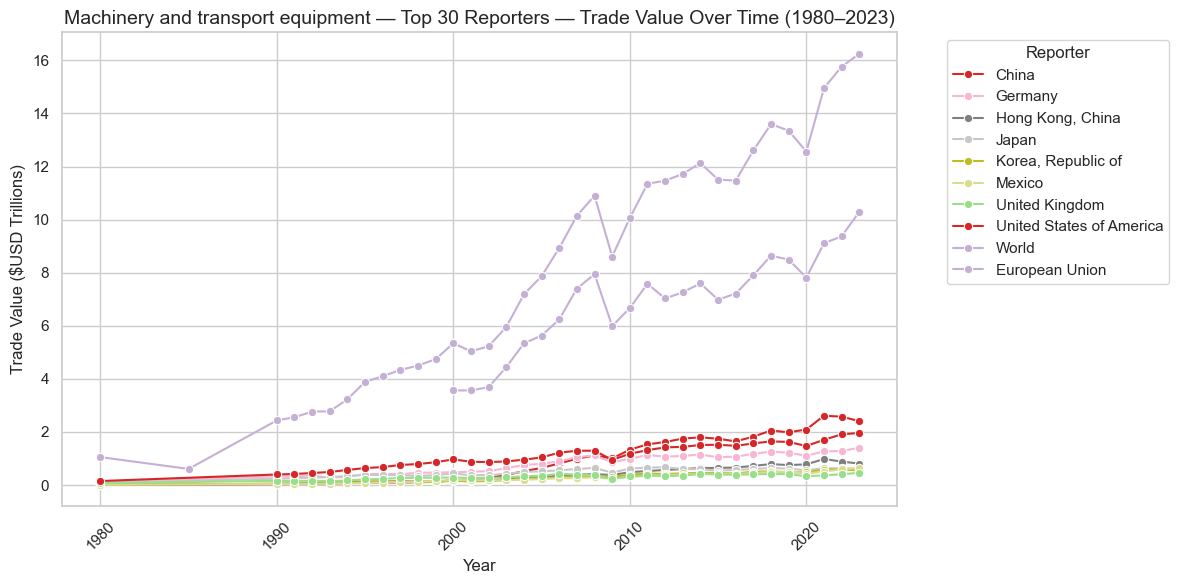

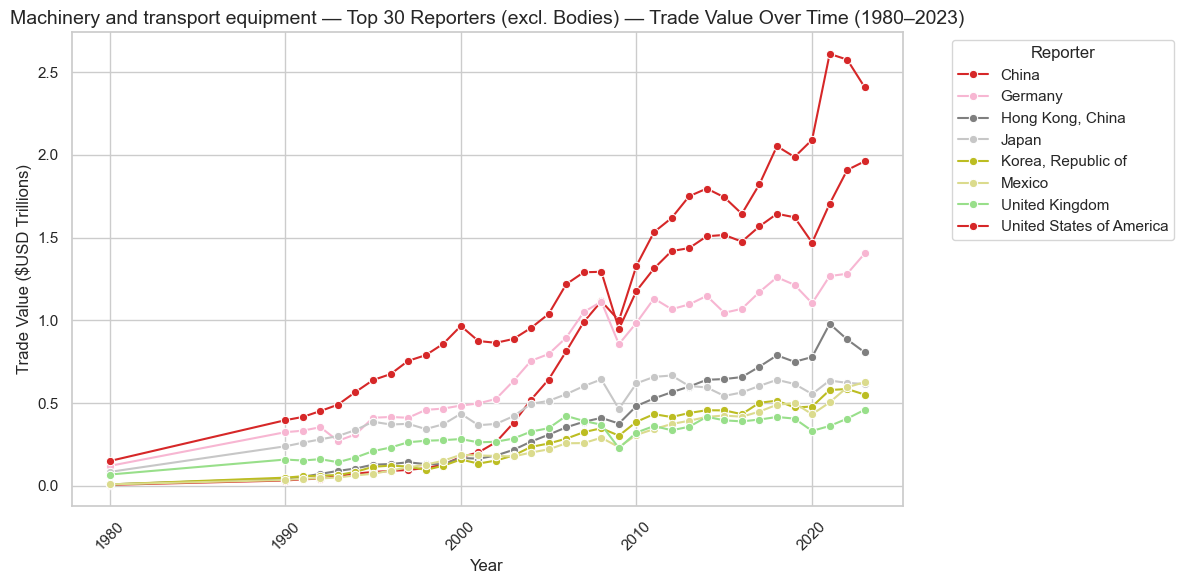

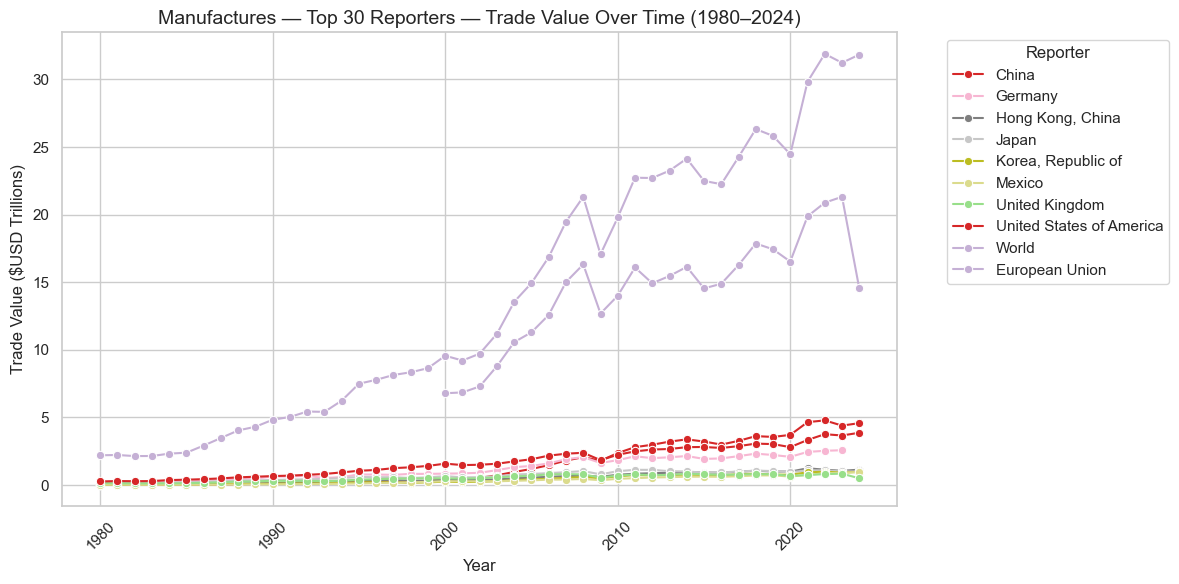

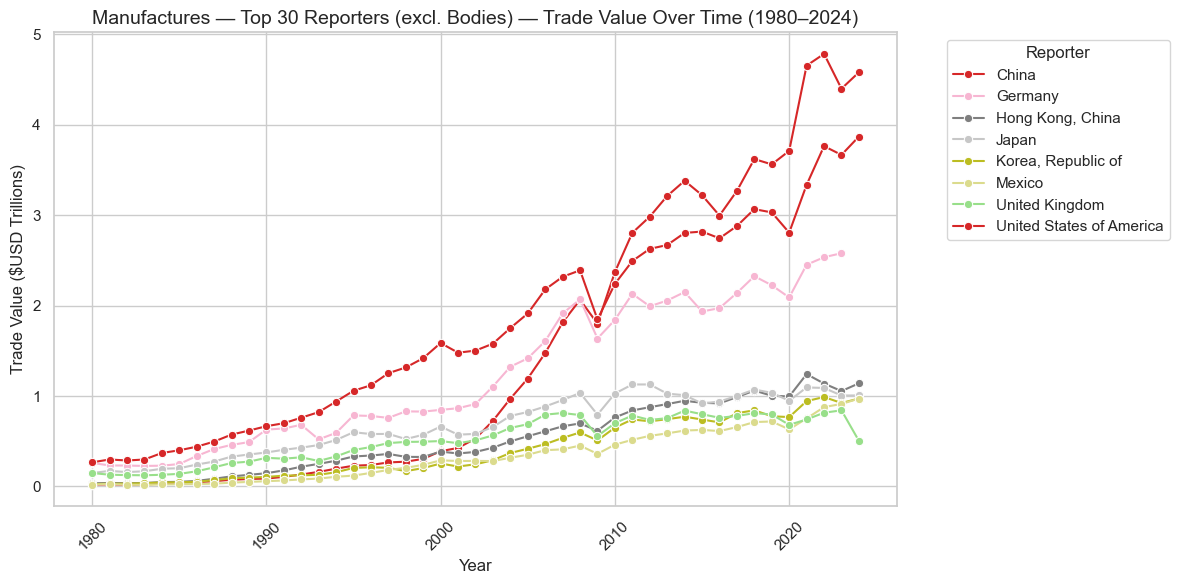

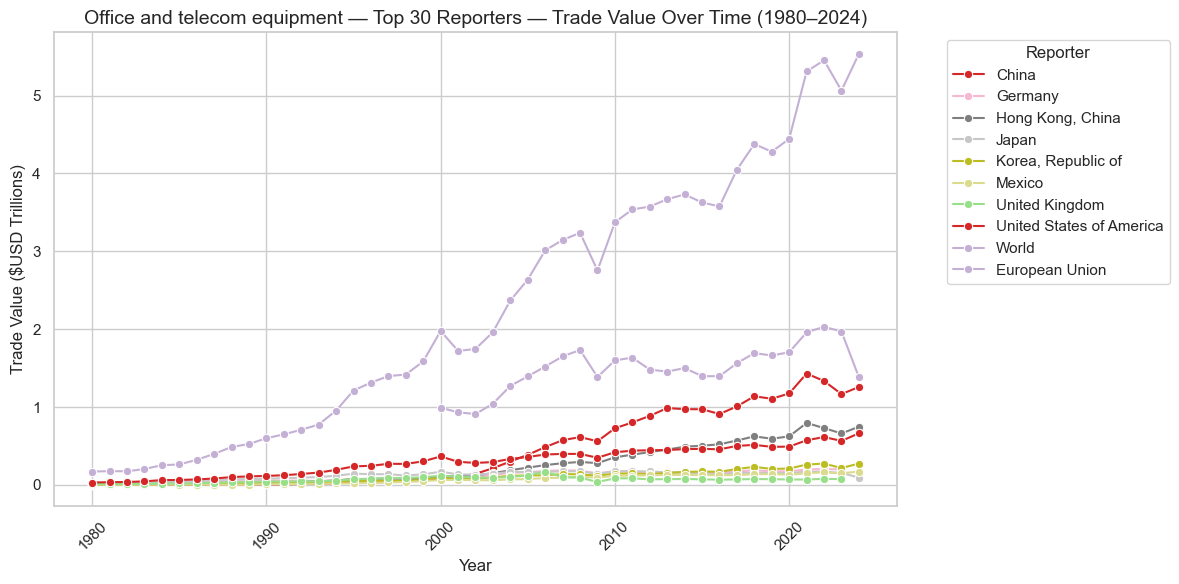

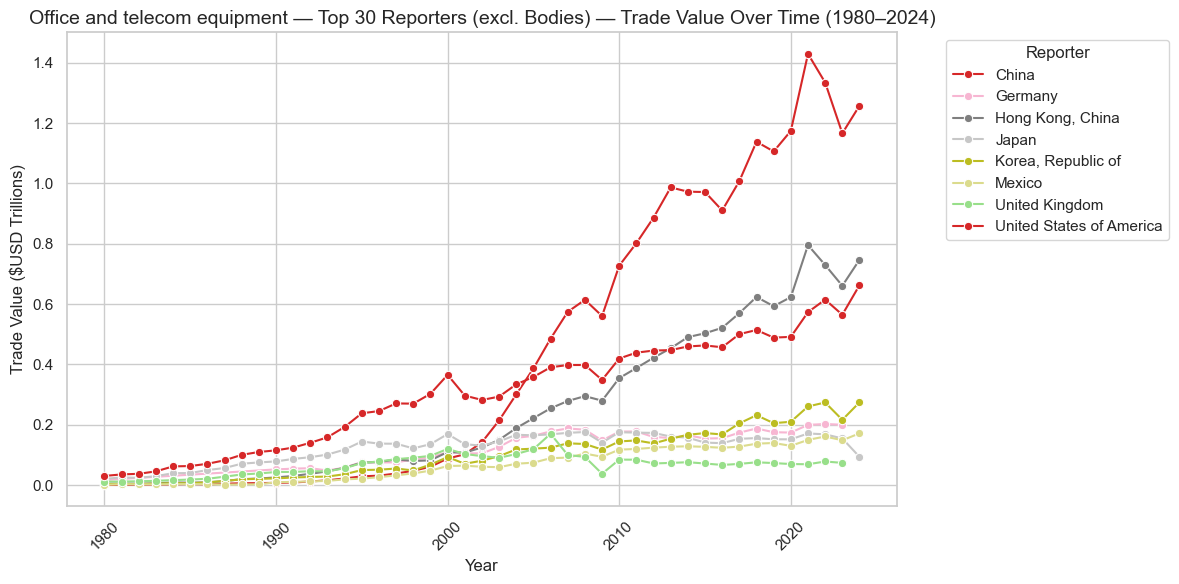

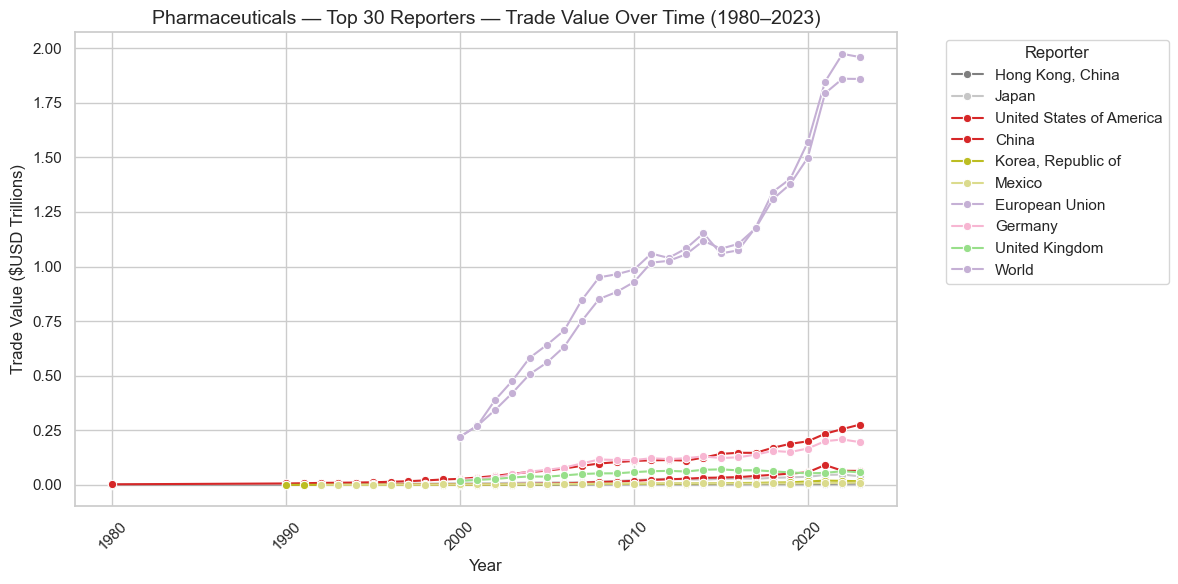

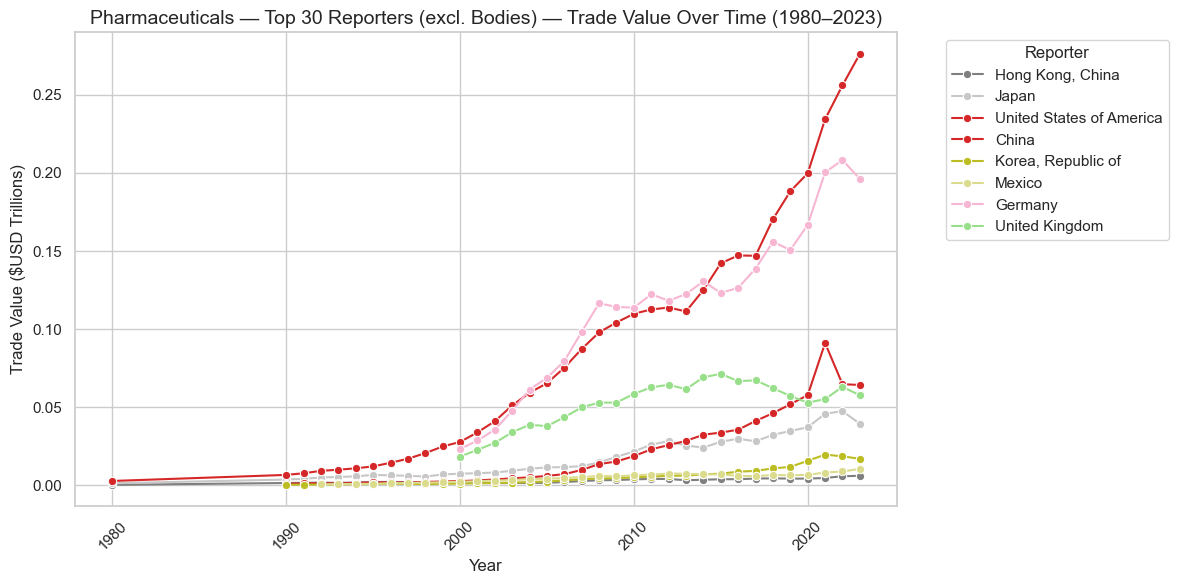

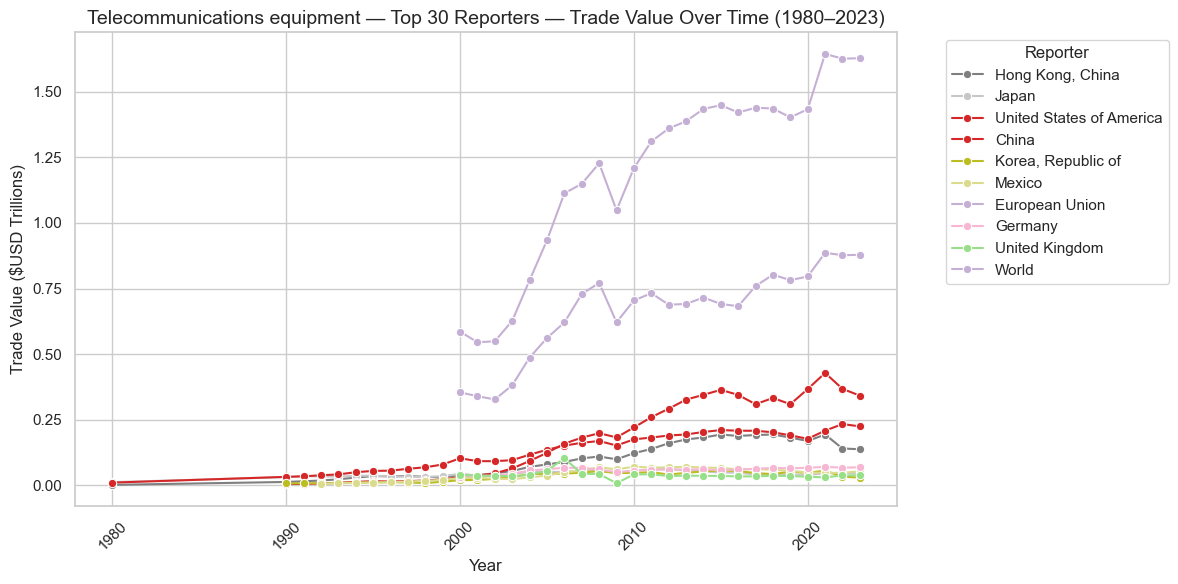

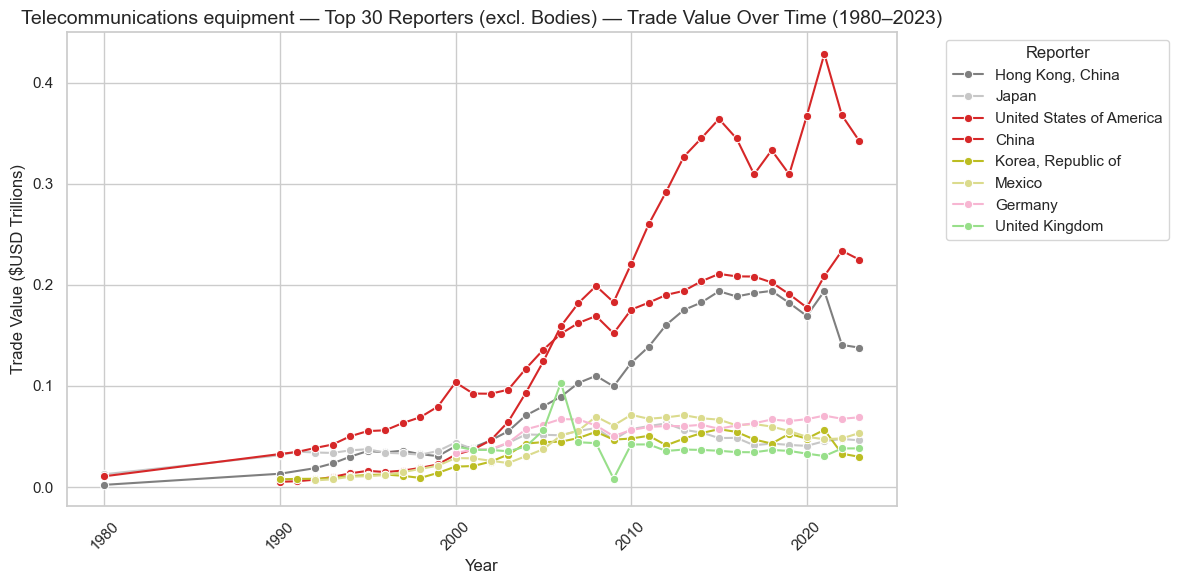

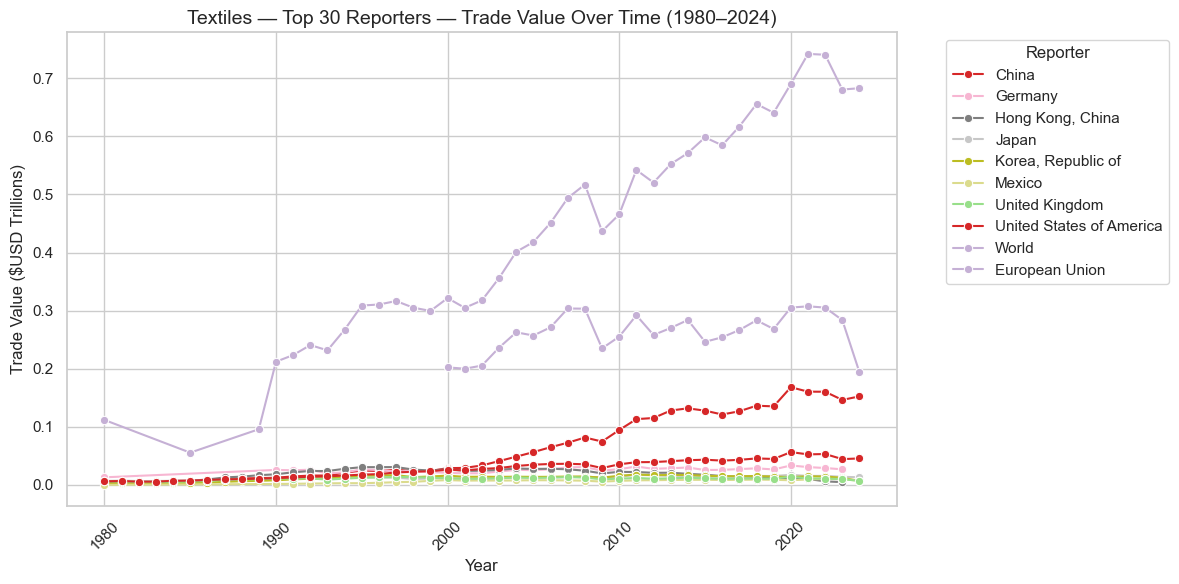

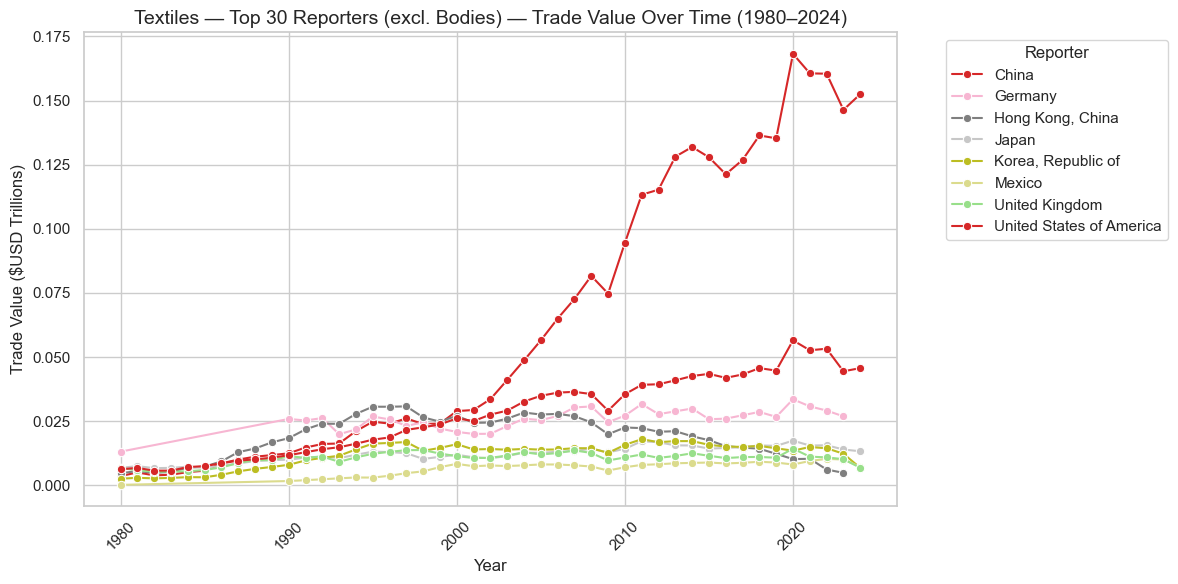

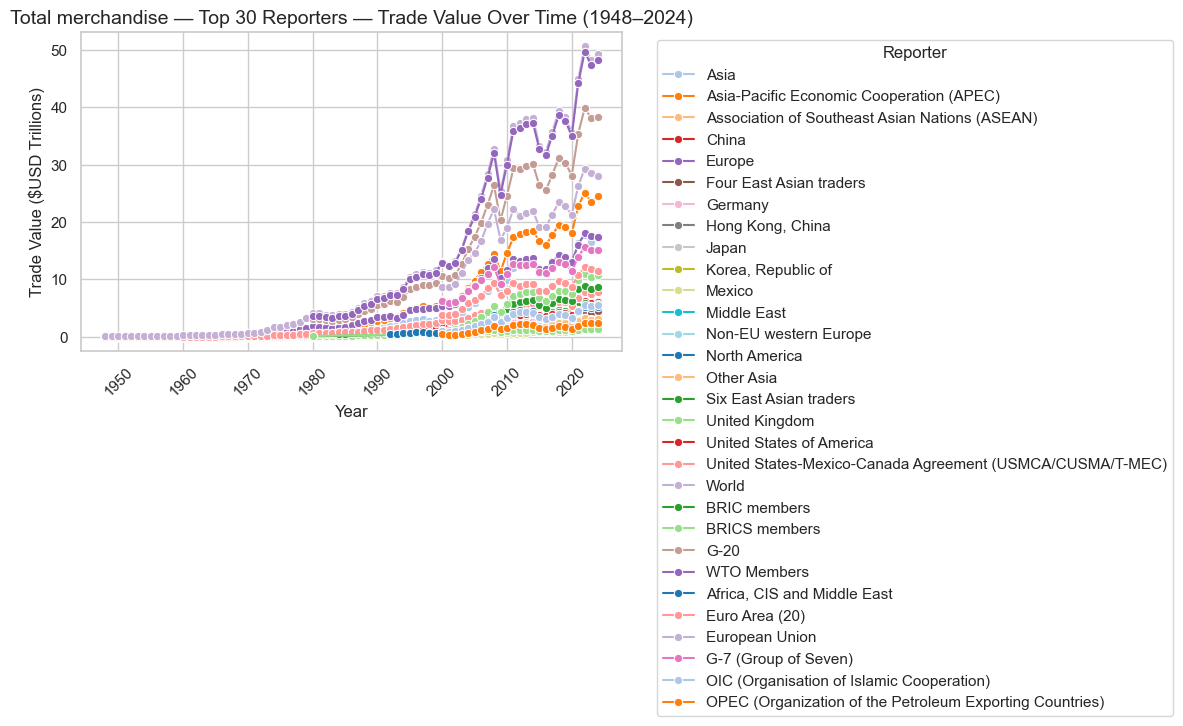

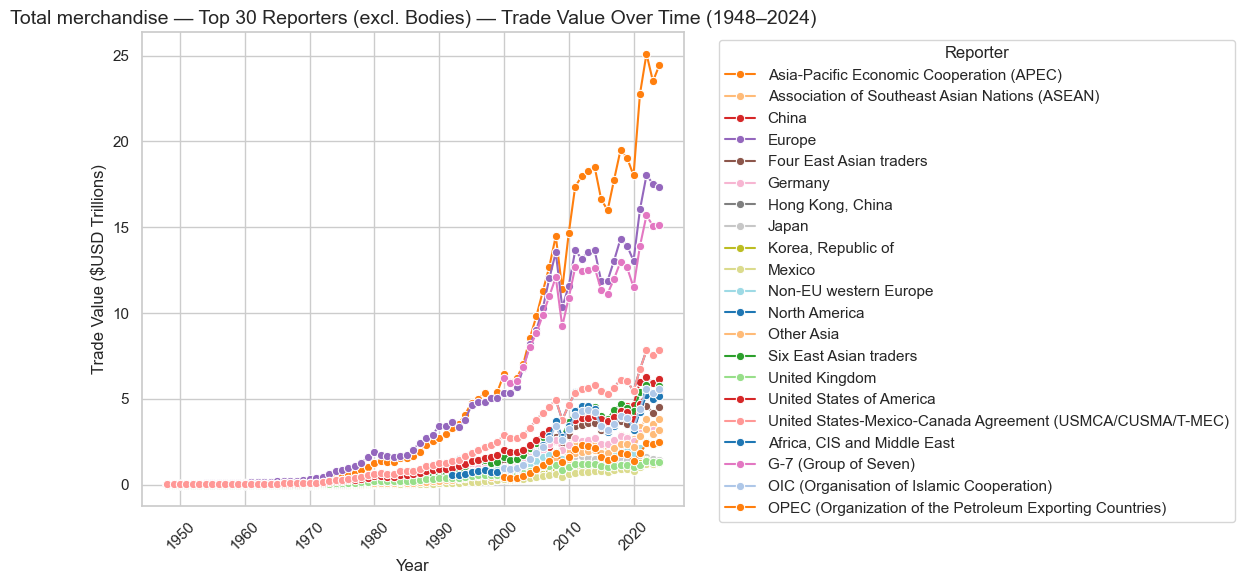

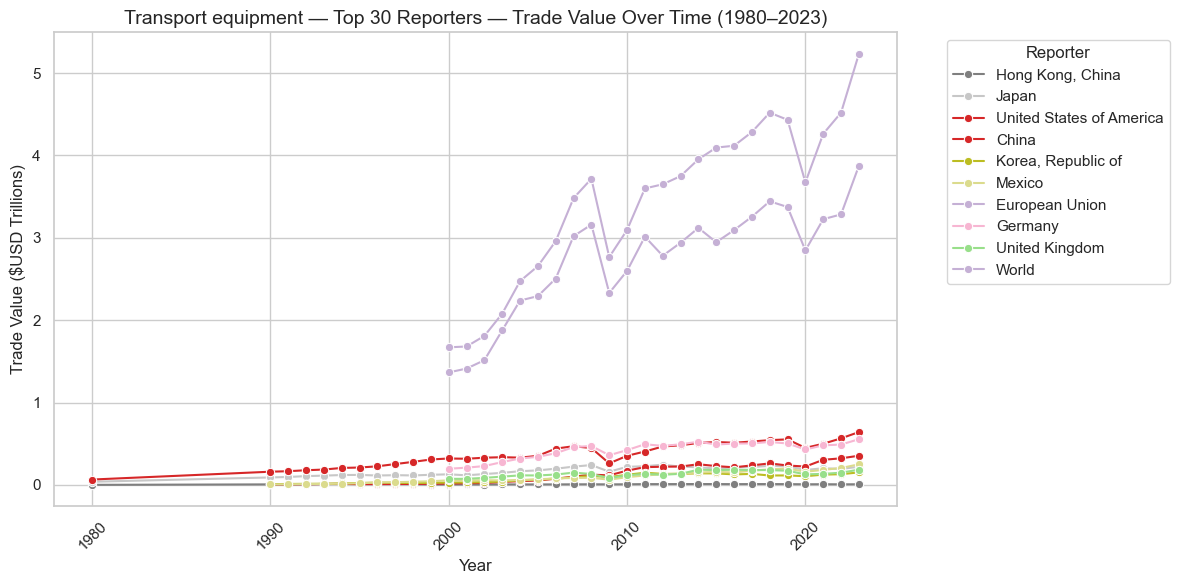

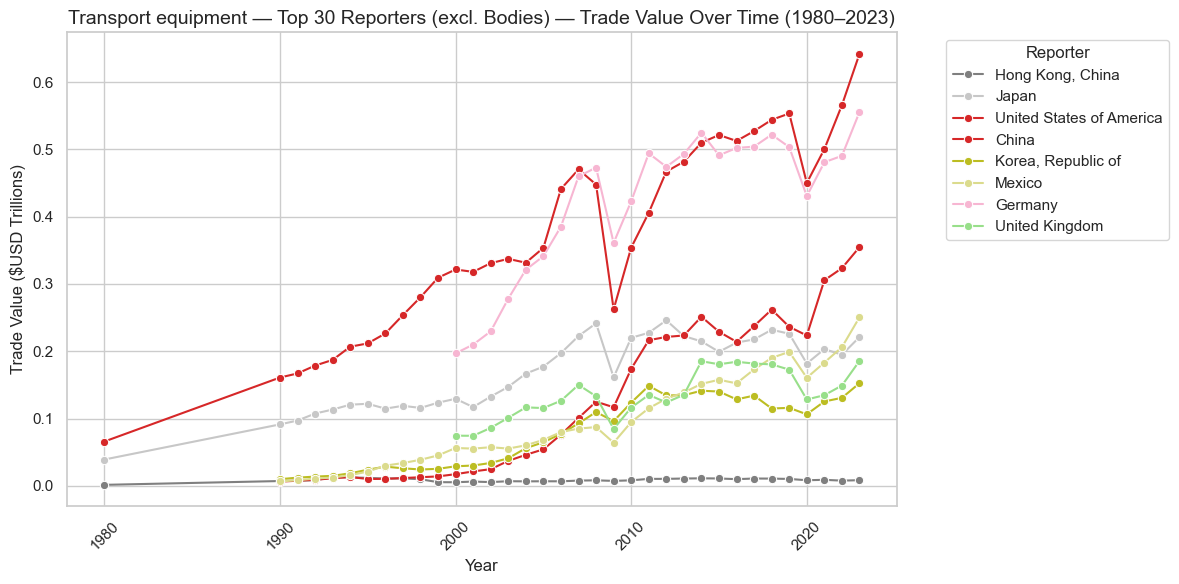

In [66]:
# Parameters
year = 2024
top = 30
excluded_reporters = ['World', 'European Union', 'BRIC members', 'BRICS members', 'G-20', 'Middle East', 'Asia', 'WTO Members', 'Euro Area (20)']
vis_path = 'visualisations/merch_products/'
os.makedirs(vis_path, exist_ok=True)

# Prepare Data
annual_merch_df['Value'] = pd.to_numeric(annual_merch_df['Value'], errors='coerce')

# Find top N reporters in the given year
top_reporters = (
    annual_merch_df[annual_merch_df['Year'] == year]
    .groupby('Reporter')['Value']
    .sum()
    .nlargest(top)
    .index
)

# Filter datasets
df_all = annual_merch_df[annual_merch_df['Reporter'].isin(top_reporters)]
df_excluded = df_all[~df_all['Reporter'].isin(excluded_reporters)]

# Convert to USD Trillions (Value originally in millions)
df_all['Value'] /= 1_000_000
df_excluded['Value'] /= 1_000_000

# Prepare grouped data
def group_by_product(df):
    return df.groupby(['Year', 'Product', 'Reporter'])['Value'].sum().reset_index()

grouped_all = group_by_product(df_all)
grouped_excluded = group_by_product(df_excluded)

# Get consistent color palette
all_reporters = sorted(set(grouped_all['Reporter']))
palette = sns.color_palette("tab20", n_colors=len(all_reporters))
reporter_color_map = dict(zip(all_reporters, palette))

# Unique products
products = sorted(set(grouped_all['Product'].dropna().unique()))

sns.set(style="whitegrid")

# Plotting Function
def plot_product(data, product, label, exclude=False):
    product_df = data[data['Product'] == product]
    if product_df.empty:
        return
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=product_df,
        x='Year',
        y='Value',
        hue='Reporter',
        marker='o',
        palette=reporter_color_map
    )

    min_year = int(product_df['Year'].min())
    max_year = int(product_df['Year'].max())
    title_suffix = f"{label} — Trade Value Over Time ({min_year}–{max_year})"
    plt.title(f"{product} — {title_suffix}", fontsize=14)
    plt.xlabel("Year")
    plt.ylabel("Trade Value ($USD Trillions)")
    plt.xticks(rotation=45)
    plt.legend(title='Reporter', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    file_suffix = "excluded" if exclude else "all"
    filename = f"{vis_path}{product}_top_{top}_{file_suffix}_trade_over_time.png"
    plt.savefig(filename, bbox_inches='tight')
    plt.show()
    plt.close()


# Run plots
for product in products:
    plot_product(grouped_all, product, f"Top {top} Reporters")
    plot_product(grouped_excluded, product, f"Top {top} Reporters (excl. Bodies)", exclude=True)

